In [1]:
import h5py
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
from pathlib import Path
import pyfftw

import bacco

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import plotter
import plot_utils
import utils
import compute_statistics as cs
import data_loader
import generate_params as genp

%load_ext autoreload
%autoreload 2

2026-01-06 23:08:25.496374: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-06 23:08:25.605282: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-06 23:08:25.605332: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-06 23:08:25.619205: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-06 23:08:25.651916: I tensorflow/core/platform/cpu_feature_guar

In [2]:
%matplotlib inline
mpl.pyplot.style.use('default')
mpl.pyplot.close('all')

font, rcnew = plot_utils.matplotlib_default_config()
mpl.rc('font', **font)
mpl.pyplot.rcParams.update(rcnew)
mpl.pyplot.style.use('tableau-colorblind10')
%config InlineBackend.figure_format = 'retina'

mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12

plt.rcParams['figure.dpi'] = 50

### fixed cosmo - for error bars 

In [3]:
data_mode = 'muchisimocks'
statistics = ['pk']

### train
# tag_params = '_p5_n10000'
# tag_biasparams = '_biaszen_p4_n10000'
# tag_noise = '_noise_p5_n10000'
# tag_Anoise = '_An_p1_n10000'
### test
# tag_params = '_test_p5_n1000'
# tag_biasparams = '_biaszen_p4_n1000'
# tag_noise = '_noise_test_p5_n1000'
# tag_Anoise = '_An_p1_n1000'
# tag_datagen = ''
## cosmic variance (quijote)
tag_params="_quijote_p0_n1000"
tag_biasparams="_b1000_p0_n1"
tag_noise="_noise_quijote_p0_n1000"
tag_Anoise="_An1_p0_n1"
tag_datagen = ''
kwargs_data = {
    'tag_datagen': tag_datagen
}

tag_stats = f'_{"_".join(statistics)}'    
tag_data = '_'+data_mode + tag_stats + tag_params + tag_biasparams + tag_datagen
k, y, y_err, idxs_params, params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, Anoise_df, Anoise_dict_fixed, random_ints, random_ints_bias = \
            data_loader.load_data(data_mode, statistics, 
                                    tag_params, tag_biasparams,
                                    tag_noise=tag_noise, tag_Anoise=tag_Anoise,
                                    tag_data=tag_data,
                                    kwargs=kwargs_data)
            
# unpack the power spectrum
k, y, y_err = k[0], y[0], y_err[0]
print(y.shape)
print(k.shape)

dir_statistics: /scratch/kstoreyf/muchisimocks/data/pks_mlib/pks_quijote_p0_n1000_b1000_p0_n1_noise_quijote_p0_n1000_An1_p0_n1
Loading muchisimocks data from /scratch/kstoreyf/muchisimocks/data/pnns_mlib/pnns_quijote_p0_n1000
Found 968 diff cosmo pnns in /scratch/kstoreyf/muchisimocks/data/pnns_mlib/pnns_quijote_p0_n1000


UnpicklingError: Failed to interpret file '/scratch/kstoreyf/muchisimocks/data/pks_mlib/pks_noise_quijote_p0_n1000/pk_n22.npy' as a pickle

In [4]:
mask = data_loader.get_Pk_mask(tag_data)

fn_mask: ../data/masks/mask_muchisimocks_pk_quijote_p0_n1000_b1000_p0_n1.txt
Loading from ../data/masks/mask_muchisimocks_pk_quijote_p0_n1000_b1000_p0_n1.txt (already exists)


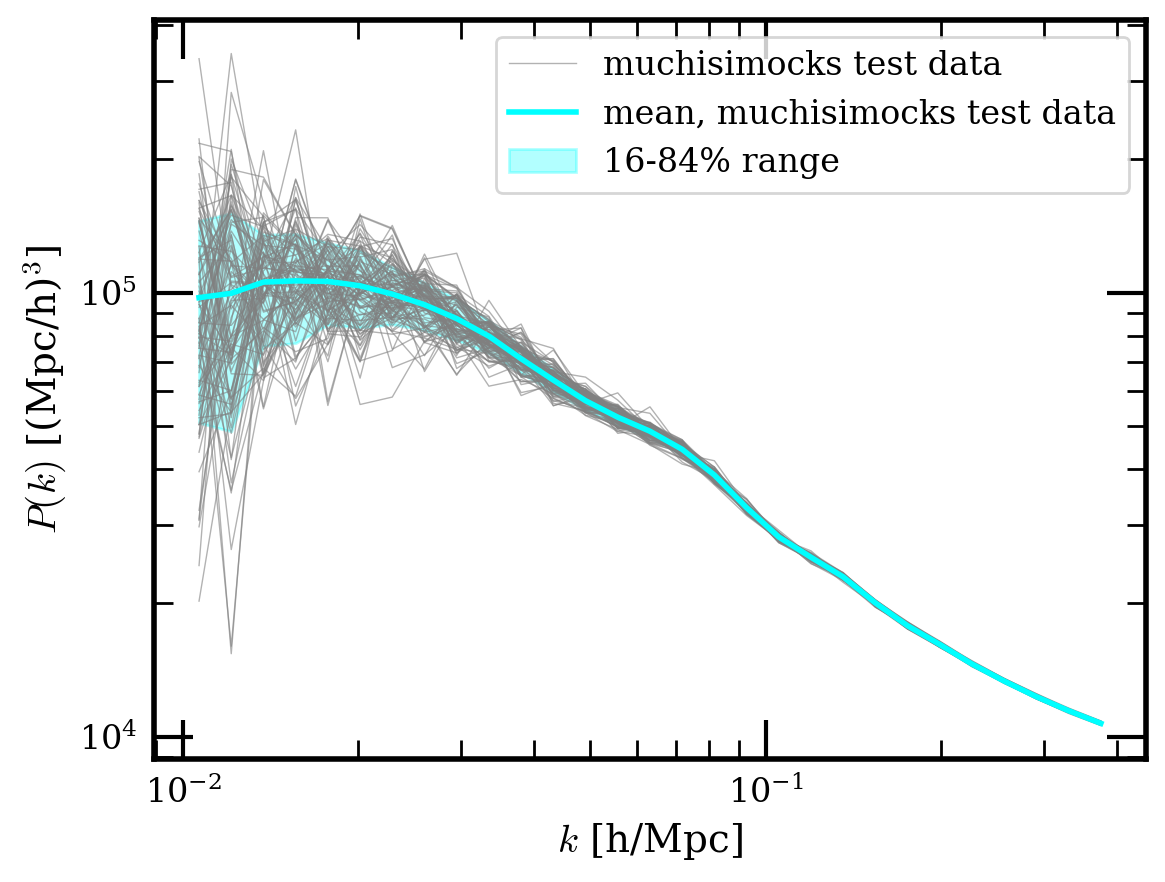

In [5]:
n_plot = 100
first = True
for i in range(n_plot):
    if first:
        label = 'muchisimocks test data'
        first = False
    else:
        label = None
    plt.plot(k, y[i], color='grey', alpha=0.6, lw=0.5, label=label)

mean = np.mean(y, axis=0)
p16 = np.percentile(y, 16, axis=0)
p84 = np.percentile(y, 84, axis=0)
plt.plot(k, mean, color='cyan', lw=2, label='mean, muchisimocks test data')
plt.fill_between(k, p16, p84, color='cyan', alpha=0.3, label=r'16-84% range')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ [h/Mpc]', fontsize=14)
plt.ylabel(r'$P(k)$ [(Mpc/h)$^3$]', fontsize=14)
plt.legend(fontsize=12)

In [6]:
err_hi = p84 - mean
err_lo = mean - p16

### loop over number densities

In [7]:
box_size = 1000.0


Load SHAMe data

In [8]:
tags_mock = ['_nbar0.00011', '_nbar0.00022', '_nbar0.00054']

k_mock_arr, y_mock_arr, y_err_mock_arr = [], [], []
for tag_mock in tags_mock:
    data_mode_test = 'shame'
    tag_data_train = None # this is used for mask; we get it below 
    statistics = ['pk', 'bispec']
    k_mock, y_mock, y_err_mock = data_loader.load_data_ood(data_mode_test, statistics, tag_mock, tag_data=tag_data_train)
    k_mock_arr.append(k_mock)
    y_mock_arr.append(y_mock)
    y_err_mock_arr.append(y_err_mock)

Loaded pk with shape (30,)
Loaded pk data with shape (30,)
No tag_data provided, so not masking data
Loaded bispec with shape (50,)
Loaded bispec data with shape (50,)
No tag_data provided, so not masking data
Loaded pk with shape (30,)
Loaded pk data with shape (30,)
No tag_data provided, so not masking data
Loaded bispec with shape (50,)
Loaded bispec data with shape (50,)
No tag_data provided, so not masking data
Loaded pk with shape (30,)
Loaded pk data with shape (30,)
No tag_data provided, so not masking data
Loaded bispec with shape (50,)
Loaded bispec data with shape (50,)
No tag_data provided, so not masking data


Load bias fields, make noiseless field 

In [9]:
dir_mocks = f'/scratch/kstoreyf/muchisimocks/muchisimocks_lib_ood/shame'
subdir_prefix = 'mock'
idx_mock = 0
fn_fields = f'{dir_mocks}/{subdir_prefix}{idx_mock}/bias_fields_eul_deconvolved_{idx_mock}.npy'
bias_terms_eul = np.load(fn_fields)

Add noise

In [10]:
noise_field_arr = []
for i, tag_mock in enumerate(tags_mock):
    
    nbar = float(tag_mock.split('nbar')[-1])

    n_grid = 128
    box_size = 1000.0  # Mpc/h
    cell_size = box_size / n_grid  # Mpc/h per cell
    cell_volume = cell_size**3
    rms_cell = 1 / np.sqrt(nbar * cell_volume)

    rng = np.random.default_rng(seed=42)

    noise_field = rms_cell * rng.standard_normal((n_grid, n_grid, n_grid))
    noise_field /= n_grid**3
    noise_field_arr.append(noise_field)

In [11]:
for i, tag_mock in enumerate(tags_mock):
    nbar = float(tag_mock.split('nbar')[-1])
    print(nbar)

0.00011
0.00022
0.00054


In [12]:
n_grid_orig = 512 # this is for the muchisimocks pipeline which is 512, even tho the shame tracer field was diff (n_grid_orig_mock)

tracer_field_arr = []
tracer_field_noiseless_arr = []
for i, tag_mock in enumerate(tags_mock):
    
    param_dict = data_loader.load_params_ood('shame', tag_mock)
    cosmo = utils.get_cosmo(param_dict)
    bias_vector = [param_dict[name] for name in utils.biasparam_names_ordered]
    
    tracer_field_noiseless = utils.get_tracer_field(bias_terms_eul, bias_vector,
                                                    n_grid_norm=n_grid_orig)
    tracer_field_noiseless_arr.append(tracer_field_noiseless)
    
    A_noise = 1
    tracer_field = utils.get_tracer_field(bias_terms_eul, bias_vector,
                                          noise_field=noise_field_arr[i], A_noise=A_noise, n_grid_norm=n_grid_orig)
    tracer_field_arr.append(tracer_field)

Compute statistics

In [13]:
pk_obj_arr = []
pk_obj_noiseless_arr = []
for i, tag_mock in enumerate(tags_mock):
    
    # cosmos are all the same, just grab one
    pk_obj_noiseless = cs.compute_pk(tracer_field_noiseless_arr[i], cosmo, box_size,
                        n_threads=1, fn_stat=None)
    pk_obj_noiseless_arr.append(pk_obj_noiseless)
    
    pk_obj = cs.compute_pk(tracer_field_arr[i], cosmo, box_size,
                            n_threads=1, fn_stat=None)
    pk_obj_arr.append(pk_obj)

Computing pk, using n_grid =  128


2025-11-27 10:33:07,026 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


2025-11-27 10:33:08,606 bacco.statistics :  ...done in 1.58 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.014938 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.043198 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000123 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2025-11-27 10:33:08,607 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-11-27 10:33:08,685 bacco.statistics :  ...done in 0.0784 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.00241 (grid1) 1.00241 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013544 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.043240 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000134 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2025-11-27 10:33:08,687 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.014413 sec
bacco.power : Counting modes


2025-11-27 10:33:08,779 bacco.statistics :  ...done in 0.092 s


bacco.power : done counting modes in 0.043037 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000138 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2025-11-27 10:33:08,780 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.00171 (grid1) 1.00171 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.014277 sec
bacco.power : Counting modes


2025-11-27 10:33:08,873 bacco.statistics :  ...done in 0.0925 s


bacco.power : done counting modes in 0.043048 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000134 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2025-11-27 10:33:08,873 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.014083 sec
bacco.power : Counting modes


2025-11-27 10:33:08,965 bacco.statistics :  ...done in 0.0915 s


bacco.power : done counting modes in 0.043155 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000133 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2025-11-27 10:33:08,966 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.00109 (grid1) 1.00109 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.014107 sec
bacco.power : Counting modes


2025-11-27 10:33:09,057 bacco.statistics :  ...done in 0.0906 s


bacco.power : done counting modes in 0.042745 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000133 secs
bacco.power : Deallocating arrays


In [14]:
pk_obj_noise_arr = []
for i, tag_mock in enumerate(tags_mock):
    pk_obj_noise = cs.compute_pk(noise_field_arr[i], cosmo, box_size,
                        n_threads=1, fn_stat=None)
    pk_obj_noise_arr.append(pk_obj_noise)

Computing pk, using n_grid =  128


2025-11-27 10:33:09,498 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-11-27 10:33:09,587 bacco.statistics :  ...done in 0.0894 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 0.00241481 (grid1) 0.00241481 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.014104 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.043237 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000129 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2025-11-27 10:33:09,589 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-11-27 10:33:09,680 bacco.statistics :  ...done in 0.0912 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 0.00170753 (grid1) 0.00170753 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013711 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.043344 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000129 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2025-11-27 10:33:09,681 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 0.00108989 (grid1) 0.00108989 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013860 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.042457 sec
bacco.power : Starting Fourier loop 


2025-11-27 10:33:09,772 bacco.statistics :  ...done in 0.0907 s


bacco.power : done Fourier loop in 0.000128 secs
bacco.power : Deallocating arrays


In [15]:
base = cs.setup_bispsec(box_size, n_grid, n_threads=1)


# Dimensions: [1.00e+03, 1.00e+03, 1.00e+03] Mpc/h
# Center: [0.00e+00, 0.00e+00, 0.00e+00] Mpc/h
# Line-of-sight: global
# Fourier-space grid: [128, 128, 128]
# Fundamental frequency: [0.006, 0.006, 0.006] h/Mpc
# Nyquist frequency: [0.402, 0.402, 0.402] h/Mpc
# Pixel window: none
# Using fftw backend
PolyBin3D setup time: 0.24 s


In [16]:
bspec_arr, bk_corr_arr = [], []
bspec_noiseless_arr, bk_corr_noiseless_arr = [], []
for i, tag_mock in enumerate(tags_mock):
    bspec, bk_corr = cs.compute_bispectrum(base, tracer_field_arr[i])
    bspec_arr.append(bspec)
    bk_corr_arr.append(bk_corr)
    
    bspec_noiseless, bk_corr_noiseless = cs.compute_bispectrum(base, tracer_field_noiseless_arr[i])
    bspec_noiseless_arr.append(bspec_noiseless)
    bk_corr_noiseless_arr.append(bk_corr_noiseless)


Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix



Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix


In [17]:
box_size_mock = 1024.0
import process_catalogs as pc
n_grid_mock = pc.round_to_nearest_even(box_size_mock / (box_size/n_grid))
print("n_grid_mock: ", n_grid_mock)

n_grid_mock:  132


In [18]:
err_lo.shape, mask.shape, pk_obj_noiseless['pk'].shape

((29,), (30,), (30,))

In [19]:
noise_amp_arr = []
for i, tag_mock in enumerate(tags_mock):
    
    nbar = float(tag_mock.split('nbar')[-1])

    n_grid = 128
    box_size = 1000.0  # Mpc/h
    cell_size = box_size / n_grid  # Mpc/h per cell
    cell_volume = cell_size**3
    rms_cell = 1 / np.sqrt(nbar * cell_volume)
    
    noise_amp = rms_cell**2 * box_size**3 / n_grid**3
    noise_amp_arr.append(noise_amp)
    print(f"nbar: {nbar}, noise_amp: {noise_amp}")

nbar: 0.00011, noise_amp: 9090.909090909092
nbar: 0.00022, noise_amp: 4545.454545454545
nbar: 0.00054, noise_amp: 1851.8518518518517


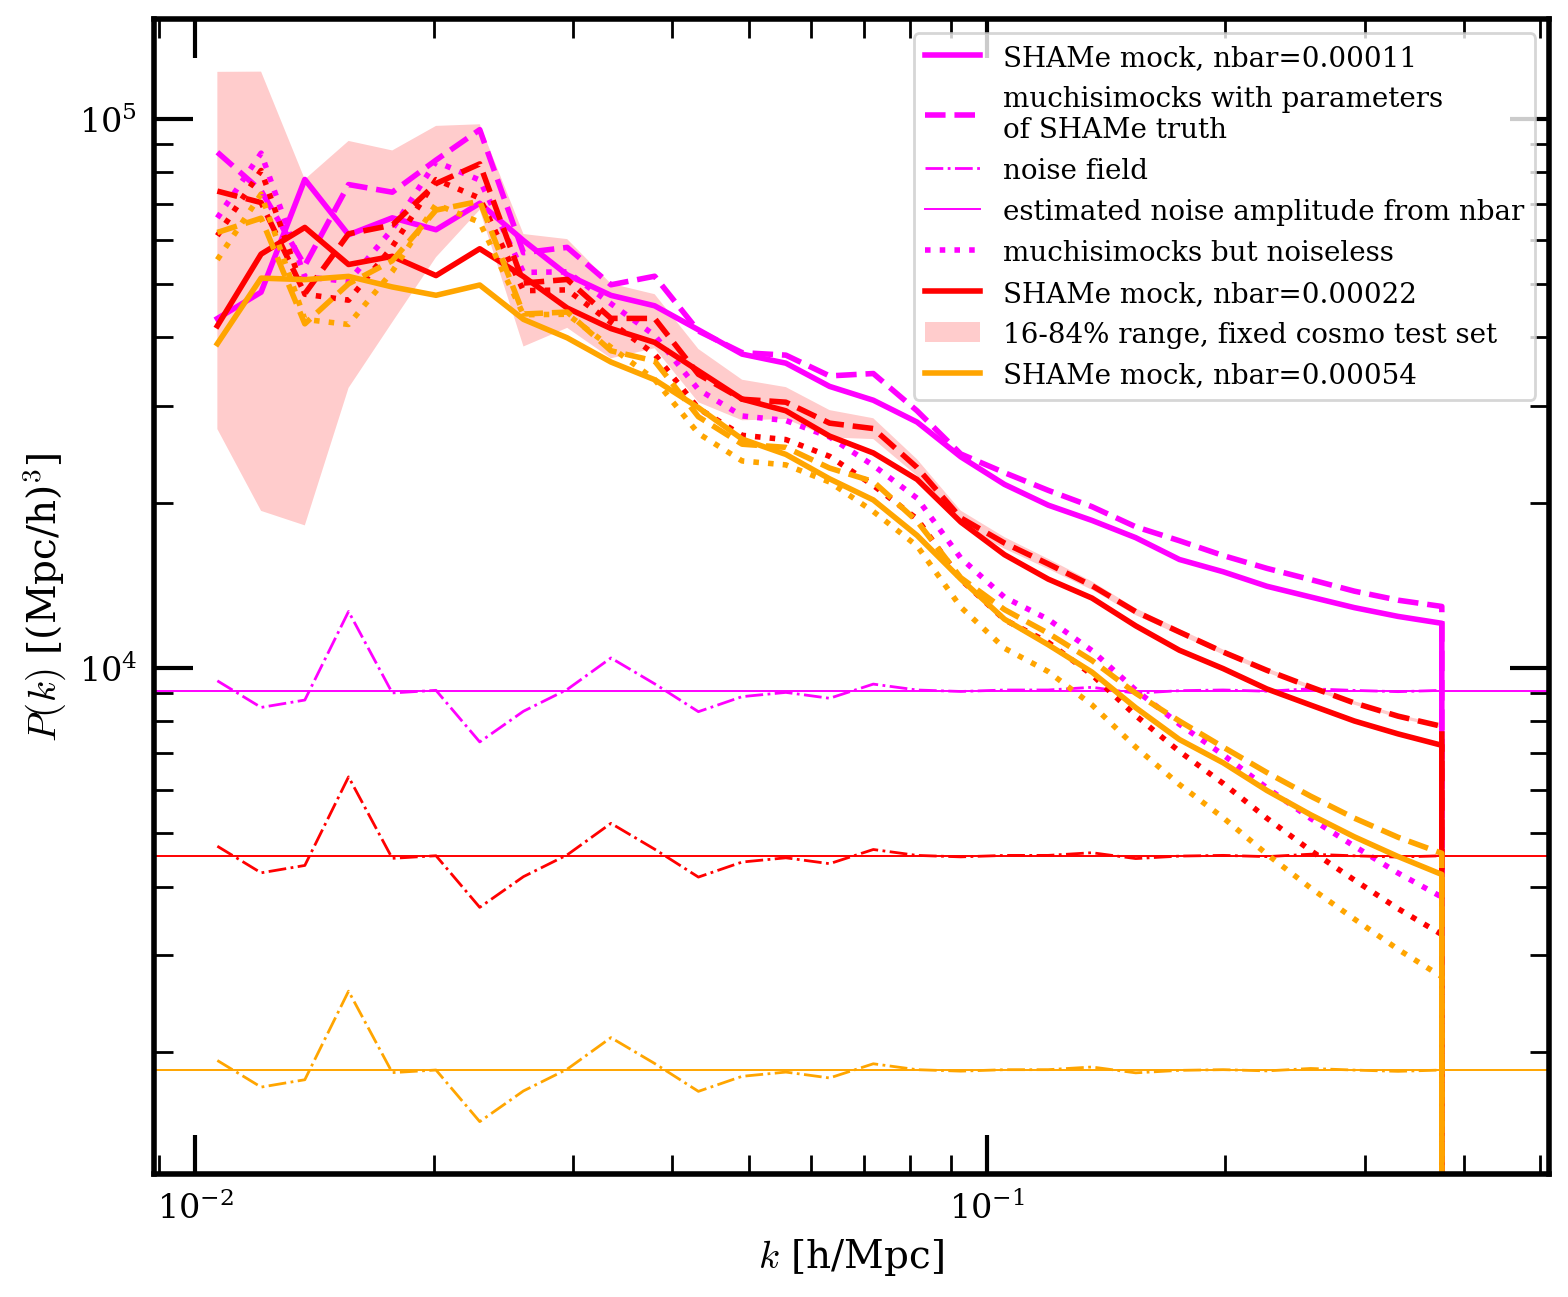

In [20]:
plt.figure(figsize=(9,7.5))
colors = ['magenta', 'red', 'orange']
for i, tag_mock in enumerate(tags_mock):
    k_mock = k_mock_arr[i]
    y_mock = y_mock_arr[i]
    pk_obj = pk_obj_arr[i]

    label = f'SHAMe mock, nbar={tag_mock.split("nbar")[-1]}'
    plt.plot(k_mock[0], y_mock[0], color=colors[i], label=label, lw=2)
    if i==0:
        label_muchisimocks = 'muchisimocks with parameters\nof SHAMe truth'
        label_noise = 'noise field'
        label_noiseamp = 'estimated noise amplitude from nbar'
        label_muchisimocks_noiseless = 'muchisimocks but noiseless'
    else:
        label_muchisimocks = None
        label_noise = None
        label_noiseamp = None
        label_muchisimocks_noiseless = None
    plt.plot(pk_obj['k'], pk_obj['pk'], color=colors[i], ls='--', label=label_muchisimocks, lw=2)
    plt.plot(pk_obj_noise_arr[i]['k'], pk_obj_noise_arr[i]['pk'], color=colors[i], ls='-.', label=label_noise, lw=1)
    
    plt.axhline(noise_amp_arr[i], color=colors[i], ls='-', lw=0.7, label=label_noiseamp)
    
    plt.plot(pk_obj_noiseless_arr[i]['k'], pk_obj_noiseless_arr[i]['pk'], color=colors[i], ls=':', label=label_muchisimocks_noiseless, lw=2)
    
    # because this is for fiducial cosmo only
    if tag_mock=='_nbar0.00022':
        label_fill = r'16-84% range, fixed cosmo test set'
        plt.fill_between(pk_obj_noiseless_arr[i]['k'][mask], pk_obj_arr[i]['pk'][mask] - err_lo, pk_obj_arr[i]['pk'][mask] + err_hi, color=colors[i], alpha=0.2, label=label_fill, edgecolor=None)
    
plt.xscale('log')
plt.yscale('log') 
plt.xlabel(r'$k$ [h/Mpc]', fontsize=14)
plt.ylabel(r'$P(k)$ [(Mpc/h)$^3$]', fontsize=14)

plt.legend(fontsize=10, loc='upper right')

2097152 2299968


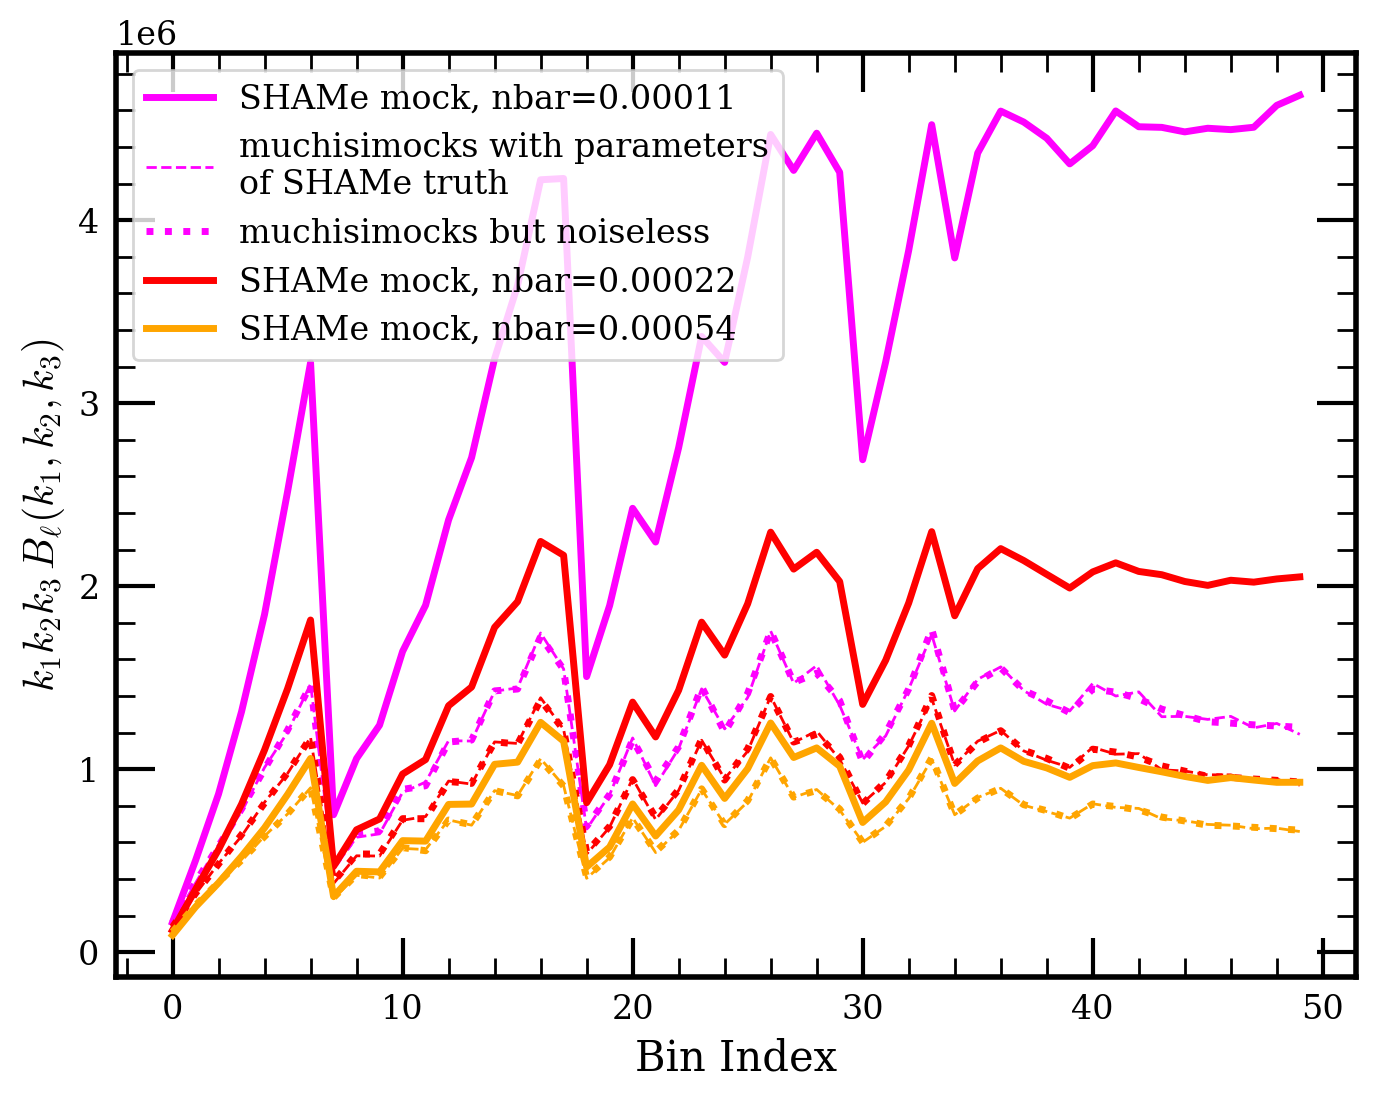

In [21]:
plt.figure(figsize=(8,6))

# ks & norm same for all
k123 = bspec.get_ks()
weight = k123.prod(axis=0)

norm = n_grid**3
norm_mock = n_grid_mock**3
print(norm, norm_mock)

for i, tag_mock in enumerate(tags_mock):
    k_mock = k_mock_arr[i]
    y_mock = y_mock_arr[i]

    label = f'SHAMe mock, nbar={tag_mock.split("nbar")[-1]}'
    if i==0:
        label_muchisimocks = 'muchisimocks with parameters\nof SHAMe truth'
        label_muchisimocks_noiseless = 'muchisimocks but noiseless'
    else:
        label_muchisimocks = None
        label_muchisimocks_noiseless = None
    plt.plot(y_mock[1], color=colors[i], label=label)
    plt.plot(norm**3 * weight*bk_corr_arr[i]['b0'], color=colors[i], ls='--', lw=1, label=label_muchisimocks)
    plt.plot(norm**3 * weight*bk_corr_noiseless_arr[i]['b0'], color=colors[i], lw=2.5, ls=':', label=label_muchisimocks_noiseless)


plt.xlabel(r'Bin Index',fontsize=15)
plt.ylabel(r'$k_1k_2k_3\,B_\ell(k_1,k_2,k_3)$',fontsize=15)
plt.legend(fontsize=12)
        

### check power spectrum from pos vs grid

In [22]:
tag_mock = '_nbar0.00022' 
nbar = tag_mock.split('nbar')[-1]
dir_cat = '../data/shame_catalogues_to_share/kate'
fn_cat0 = f'{dir_cat}/kate_sham_catalogue_a1.0_par_b_Planck_N3072_L1024_0.00_{nbar}.h5'
fn_catpi = f'{dir_cat}/kate_sham_catalogue_a1.0_par_b_Planck_N3072_L1024_3.14_{nbar}.h5'

data_mode = 'shame'

# Grid and box parameters
box_size_muchisimocks = 1000.0
box_size_mock = 1024.0
n_grid_target = 128
n_grid_mock = utils.round_to_nearest_even(box_size_mock / (box_size_muchisimocks/n_grid_target))

In [23]:
# Load catalog
with h5py.File(fn_cat0, 'r') as cat:
    positions_0 = cat['gal_pos'][:]
    n_galaxies_0 = len(positions_0)

In [24]:
# Load catalog
with h5py.File(fn_catpi, 'r') as cat:
    positions_pi = cat['gal_pos'][:]
    n_galaxies_pi = len(positions_pi)

In [25]:
cosmo = utils.get_cosmo(utils.cosmo_dict_shame)

In [26]:
log_binning=True
normalise_grid=True #??
deconvolve_grid=False
interlacing=False
deposit_method='cic'
correct_grid=False
n_threads=8

# fixing these here to ensure binning is same for all stats computed!
k_min = 0.01
k_max = 0.4
n_bins = 30
    
    
args_power = {
    # "grid1": None,
    # "grid2": None,
    "normalise_grid1": normalise_grid, #default: False
    "normalise_grid2": normalise_grid, #default: False
    "deconvolve_grid1": deconvolve_grid, #default: False
    "deconvolve_grid2": deconvolve_grid, #default: False
    #"ngrid": n_grid_mock,
    "box": box_size_mock,
    "mass1": None,
    "mass2": None,
    "interlacing": interlacing, #default: True
    "deposit_method": deposit_method, #default: "tsc",
    "log_binning": log_binning,
    #"pk_lt": None,
    "kmin": k_min,
    "kmax": k_max,
    "nbins": n_bins,
    "correct_grid": correct_grid,
    "zspace": False,
    "cosmology": cosmo,
    #"pmulti_interp": "polyfit",
    "nthreads": n_threads,
    #"compute_correlation": False, #default: True
    #"compute_power2d": False, #default: True
    "folds": 1,
    #"totalmass1": None,
    #"totalmass2": None,
    #"jack_error": False,
    #"n_jack": None
}

pknbody_dict = {
    #'ngrid': n_grid_mock,
    'min_k': k_min,
    'log_binning': log_binning,
    'log_binning_kmax': k_max,
    'log_binning_nbins': n_bins,
    'interlacing': interlacing,
    'depmethod': deposit_method,
    'correct_grid': correct_grid,
    'folds': 1 #default
}
bacco.configuration.update({'number_of_threads': n_threads})
bacco.configuration.update({'pknbody': pknbody_dict})
bacco.configuration.update({'pk' : {'maxk' : k_max}})
#bacco.configuration.update({'scaling' : {'disp_ngrid' : n_grid_mock}})

In [27]:
pk_obj_pos = bacco.statistics.compute_crossspectrum(
        pos1=positions_0,
        pos2=positions_0,
        **args_power)

2025-11-27 10:33:38,404 bacco.statistics : Computing the cross power spectrum with ngrid=256 and interlacing=False
2025-11-27 10:33:39,797 bacco.statistics : Computing cic mesh with ngrid=256 and interlacing=False
2025-11-27 10:33:39,798 bacco.statistics : starting deposit 1
2025-11-27 10:33:39,816 bacco.statistics :  mesh done in 0.0197 s
2025-11-27 10:33:39,817 bacco.statistics : Computing cic mesh with ngrid=256 and interlacing=False
2025-11-27 10:33:39,817 bacco.statistics : starting deposit 1
2025-11-27 10:33:39,836 bacco.statistics :  mesh done in 0.0186 s


bacco.mesh : boxsize=1024.000000 ngrid=256, nthreads=8, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 64.0 Mb
bacco.mesh : binning of 236223 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.mesh : boxsize=1024.000000 ngrid=256, nthreads=8, vel_factor=0.000000, interlacing=0, folds=1.000000, 2d=0
bacco.mesh : allocating 64.0 Mb
bacco.mesh : binning of 236223 particles (1 with mass)
bacco.mesh : Using mass = 1.000000
bacco.power : boxsize 1024.000000; ngrid 256; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=1 normalise_grid2=1 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 236223 (grid1) 236223 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.087103 sec
bacco.power : Counting modes


2025-11-27 10:33:40,061 bacco.statistics :  ...done in 1.66 s


bacco.power : done counting modes in 0.095254 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000271 secs
bacco.power : Deallocating arrays


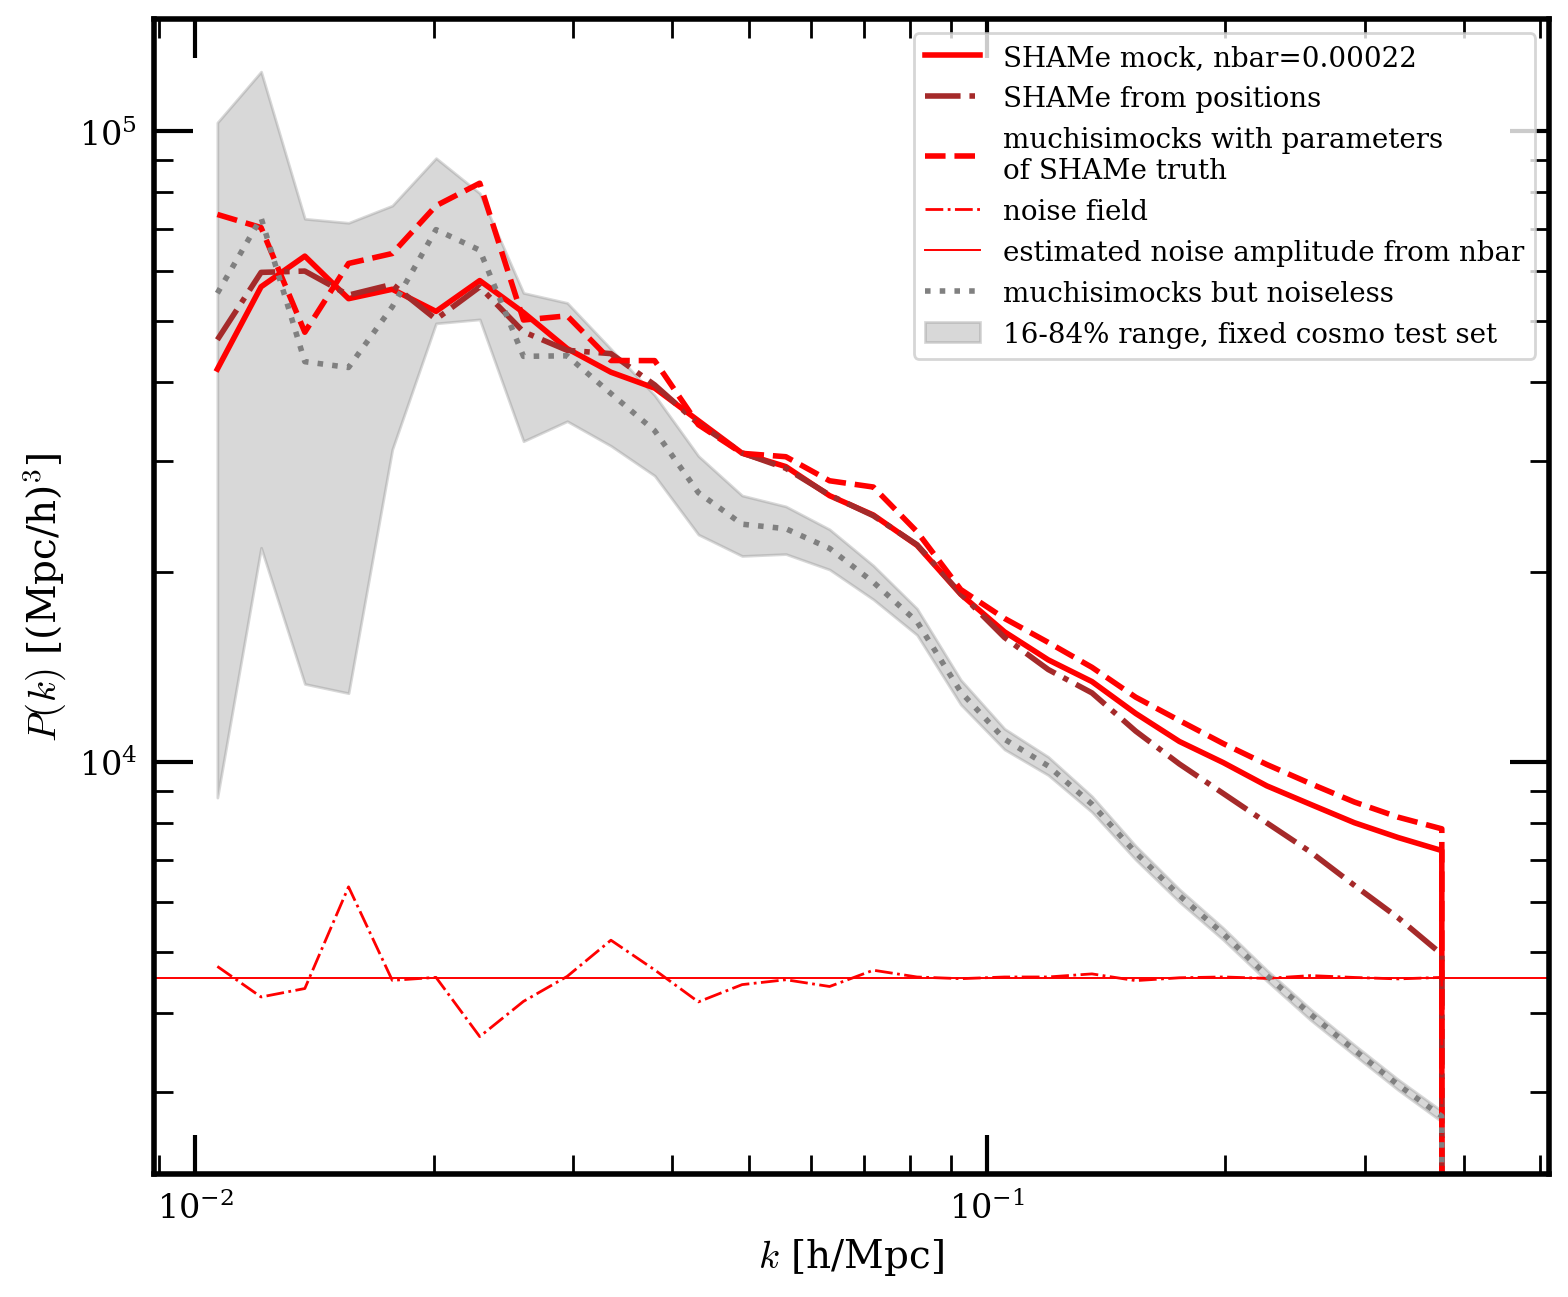

In [28]:
plt.figure(figsize=(9,7.5))
colors = ['magenta', 'red', 'orange']
i = 1  # for nbar0.00022

k_mock = k_mock_arr[i]
y_mock = y_mock_arr[i]
pk_obj = pk_obj_arr[i]

label = f'SHAMe mock, nbar={tag_mock.split("nbar")[-1]}'
plt.plot(k_mock[0], y_mock[0], color=colors[i], label=label, lw=2)
# TODO careful this is just for first mock! 
plt.plot(pk_obj_pos['k'], pk_obj_pos['pk'], color='brown', label='SHAMe from positions', lw=2, alpha=1, ls='-.')

label_muchisimocks = 'muchisimocks with parameters\nof SHAMe truth'
label_noise = 'noise field'
label_noiseamp = 'estimated noise amplitude from nbar'
plt.plot(pk_obj['k'], pk_obj['pk'], color=colors[i], ls='--', label=label_muchisimocks, lw=2)

plt.plot(pk_obj_noise_arr[i]['k'], pk_obj_noise_arr[i]['pk'], color=colors[i], ls='-.', label=label_noise, lw=1)

plt.axhline(noise_amp_arr[i], color=colors[i], ls='-', lw=0.7, label=label_noiseamp)
    
#plt.plot(pk_obj_pos['k'], pk_obj_pos['pk']/n_grid_mock**6, color=colors[i], label='from positions', lw=1.4, alpha=0.5)

plt.plot(pk_obj_noiseless['k'], pk_obj_noiseless['pk'], color='grey', ls=':', label='muchisimocks but noiseless', lw=2)
plt.fill_between(pk_obj_noiseless['k'][mask], pk_obj_noiseless['pk'][mask] - err_lo, pk_obj_noiseless['pk'][mask] + err_hi, color='grey', alpha=0.3, label=r'16-84% range, fixed cosmo test set')
plt.xscale('log')
plt.yscale('log') 
plt.xlabel(r'$k$ [h/Mpc]', fontsize=14)
plt.ylabel(r'$P(k)$ [(Mpc/h)$^3$]', fontsize=14)

plt.legend(fontsize=10, loc='upper right')

## Try bispectrum noise model

In [29]:
from scipy.interpolate import interp1d

i = 1
P_interp_log = interp1d(np.log(pk_obj_arr[i]['k']), np.log(pk_obj_arr[i]['pk']), kind='linear',
                       bounds_error=False, fill_value='extrapolate')

def P_interp_loglog(k):
    return np.exp(P_interp_log(np.log(k)))

/tmp/ipykernel_1010509/1022027459.py:4: RuntimeWarning: divide by zero encountered in log
  P_interp_log = interp1d(np.log(pk_obj_arr[i]['k']), np.log(pk_obj_arr[i]['pk']), kind='linear',


In [30]:
eps0_b = 0.1
eps1_b = 0.1
eps2_b = -0.9
eps3_b = 1
eps4_b = 1

nbar = float(tags_mock[i].split('nbar')[-1])
k1, k2, k3 = k123
fP1, fP2, fP3 = P_interp_loglog(k1), P_interp_loglog(k2), P_interp_loglog(k3)
    
term0 = (1/nbar**2) * (1 + eps0_b + eps1_b*(k1**2 + k2**2 + k3**2))
term1 = (1 + eps2_b)/nbar * (fP1 + fP2 + fP3)
term2 = eps3_b/nbar * (fP1*(k2**2 + k3**2) + fP2*(k1**2 + k3**2) + fP3*(k1**2 + k2**2))
term3 = eps4_b/nbar * (fP1*k1**2 + fP2*k2**2 + fP3*k3**2)

bispec_noise = term0 + term1 + term2 + term3
bispec_noise /= n_grid**9  # to match normalization of bispec from compute_bispectrum

In [31]:
# ks & norm same for all
k123 = bspec.get_ks()
weight = k123.prod(axis=0)

norm = n_grid**3
norm_mock = n_grid_mock**3

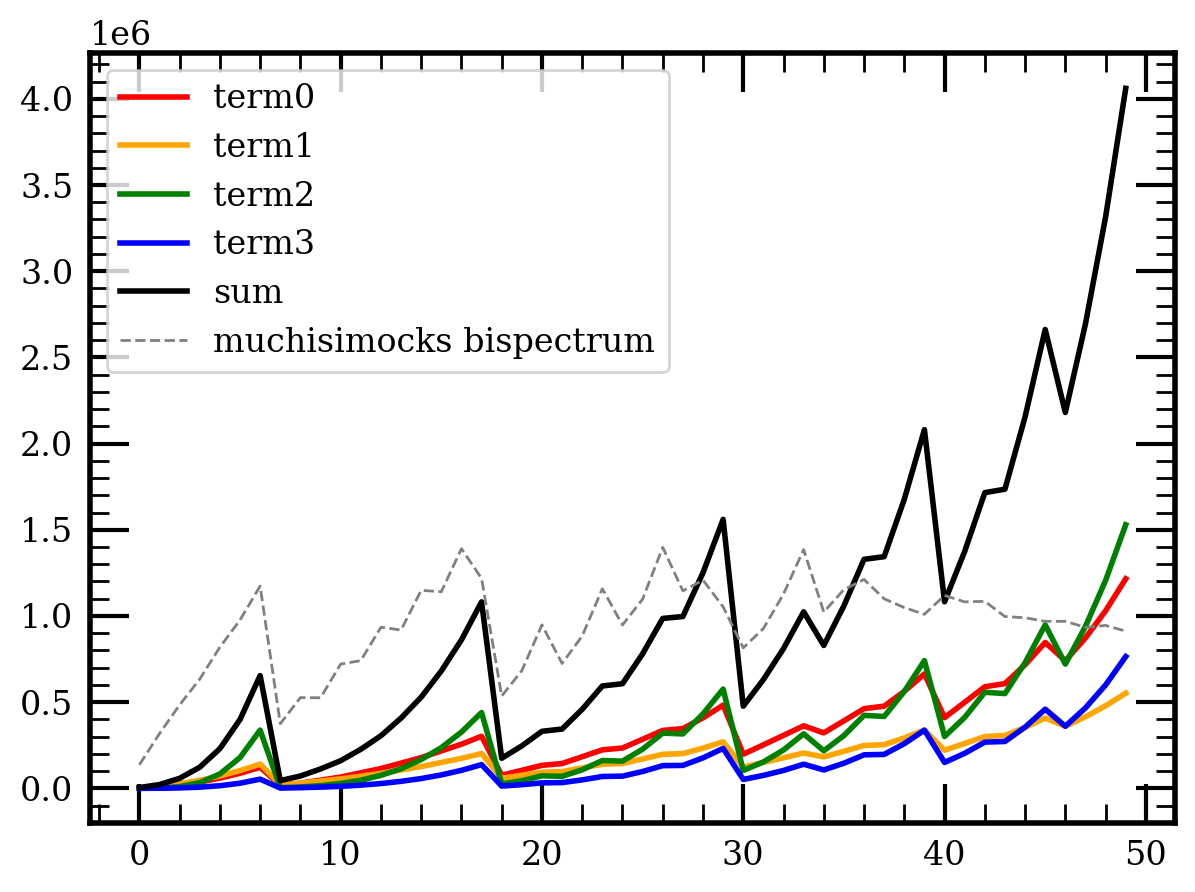

In [32]:
plt.figure(figsize=(7,5))

plt.plot(norm**3 * weight*term0/n_grid**9, color='red', ls='-', lw=2, label='term0')
plt.plot(norm**3 * weight*term1/n_grid**9, color='orange', ls='-', lw=2, label='term1')
plt.plot(norm**3 * weight*term2/n_grid**9, color='green', ls='-', lw=2, label='term2')
plt.plot(norm**3 * weight*term3/n_grid**9, color='blue', ls='-', lw=2, label='term3')
plt.plot(norm**3 * weight*(term0 + term1 + term2 + term3)/n_grid**9, color='black', lw=2, label='sum')
#plt.plot(bispec_noise, color='black', lw=2, label='sum')
i = 1
plt.plot(norm**3 * weight*bk_corr_arr[i]['b0'], color='grey', ls='--', lw=1, label='muchisimocks bispectrum')
plt.legend(fontsize=12)

In [33]:
from scipy.optimize import minimize
from scipy.interpolate import interp1d
import numpy as np

def fit_bispectrum_noise_model(bispectrum_data, bispectrum_mock_noiseless, k123, pk_obj, nbar, n_grid, 
                               terms_to_include=[0, 1, 2, 3], initial_eps=None, method='least_squares'):
    """
    Fit eps parameters for bispectrum noise model.
    terms_to_include: 0=term0(eps0,eps1), 1=term1(eps2), 2=term2(eps3), 3=term3(eps4)
    """
    # Power spectrum interpolation
    P_interp_log = interp1d(np.log(pk_obj['k']), np.log(pk_obj['pk']), 
                           kind='linear', bounds_error=False, fill_value='extrapolate')
    P_interp_loglog = lambda k: np.exp(P_interp_log(np.log(k)))
    
    k1, k2, k3 = k123
    fP1, fP2, fP3 = P_interp_loglog(k1), P_interp_loglog(k2), P_interp_loglog(k3)
    weight, norm = k123.prod(axis=0), n_grid**3
    
    # Parameter mapping: term0 needs 2 params, others need 1
    param_count = 2 if 0 in terms_to_include else 0
    param_count += sum(1 for i in [1, 2, 3] if i in terms_to_include)

    def bispectrum_noise_model(eps_params):
        # Map parameters to eps values
        idx = 0
        eps = [0] * 5  # [eps0_b, eps1_b, eps2_b, eps3_b, eps4_b]
        if 0 in terms_to_include:
            eps[0], eps[1] = eps_params[idx], eps_params[idx+1]
            idx += 2
        for term_idx, eps_idx in zip([1, 2, 3], [2, 3, 4]):
            if term_idx in terms_to_include:
                eps[eps_idx] = eps_params[idx]
                idx += 1
        
        # Calculate terms
        terms = [
            (1/nbar**2) * (1 + eps[0] + eps[1]*(k1**2 + k2**2 + k3**2)), # shot noise
            (1 + eps[2])/nbar * (fP1 + fP2 + fP3), # shot noise x P(k)
            eps[3]/nbar * (fP1*(k2**2 + k3**2) + fP2*(k1**2 + k3**2) + fP3*(k1**2 + k2**2)), # higher order
            eps[4]/nbar * (fP1*k1**2 + fP2*k2**2 + fP3*k3**2) # higher order
        ]
        
        return sum(terms[i] for i in terms_to_include) / n_grid**9
    
    def objective(eps_params):
        bispec_noise = bispectrum_noise_model(eps_params)
        model = norm**3 * weight * (bispectrum_mock_noiseless + bispec_noise)
        if method == 'least_squares':
            return np.sum((bispectrum_data - model)**2)
        elif method == 'chi_squared':
            return np.sum(((bispectrum_data - model) / (np.abs(bispectrum_data) * 0.1))**2)
        else:
            raise ValueError("method must be 'least_squares' or 'chi_squared'")
    
    # Optimization
    initial_eps = initial_eps or [1.0] * param_count
    result = minimize(objective, initial_eps, method='BFGS')
    
    # Return results
    model_bispec = bispectrum_noise_model(result.x)
    return {
        'eps_fitted': result.x,
        'terms_included': terms_to_include,
        'model_bispectrum': model_bispec,
        'chi_squared': np.sum((bispectrum_data - model_bispec)**2),
        'success': result.success
    }

# Usage
i = 1
nbar = float(tags_mock[i].split('nbar')[-1])

fit_term0 = fit_bispectrum_noise_model(y_mock_arr[i][1], bk_corr_noiseless_arr[i]['b0'], 
                                       k123, pk_obj_arr[i], nbar, n_grid, [0])
fit_term01 = fit_bispectrum_noise_model(y_mock_arr[i][1], bk_corr_noiseless_arr[i]['b0'], 
                                        k123, pk_obj_arr[i], nbar, n_grid, [0, 1])
fit_termsall = fit_bispectrum_noise_model(y_mock_arr[i][1], bk_corr_noiseless_arr[i]['b0'], 
                                     k123, pk_obj_arr[i], nbar, n_grid)

print("Term0 only:", fit_term0['eps_fitted'])
print("Term0+1:", fit_term01['eps_fitted']) 
print("All terms:", fit_termsall['eps_fitted'])

Term0 only: [ 3.63969426 -9.01992613]
Term0+1: [-1.10108588 -4.82017712 -0.40354669]
All terms: [  9.16698501  72.5281806   -1.01804898   1.37838793 -57.45594591]


/tmp/ipykernel_1010509/18912126.py:12: RuntimeWarning: divide by zero encountered in log
  P_interp_log = interp1d(np.log(pk_obj['k']), np.log(pk_obj['pk']),
/tmp/ipykernel_1010509/18912126.py:12: RuntimeWarning: divide by zero encountered in log
  P_interp_log = interp1d(np.log(pk_obj['k']), np.log(pk_obj['pk']),
/tmp/ipykernel_1010509/18912126.py:12: RuntimeWarning: divide by zero encountered in log
  P_interp_log = interp1d(np.log(pk_obj['k']), np.log(pk_obj['pk']),


In [39]:
eps0_b, eps1_b, eps2_b = 0,0,0
term0 = (1/nbar**2) * (1 + eps0_b + eps1_b*(k1**2 + k2**2 + k3**2))
term1 = (1 + eps2_b)/nbar * (fP1 + fP2 + fP3)

bispec_noise0s = term0 + term1
bispec_noise0s /= n_grid**9  # to match normalization of bispec from compute_bispectrum

2097152 2299968


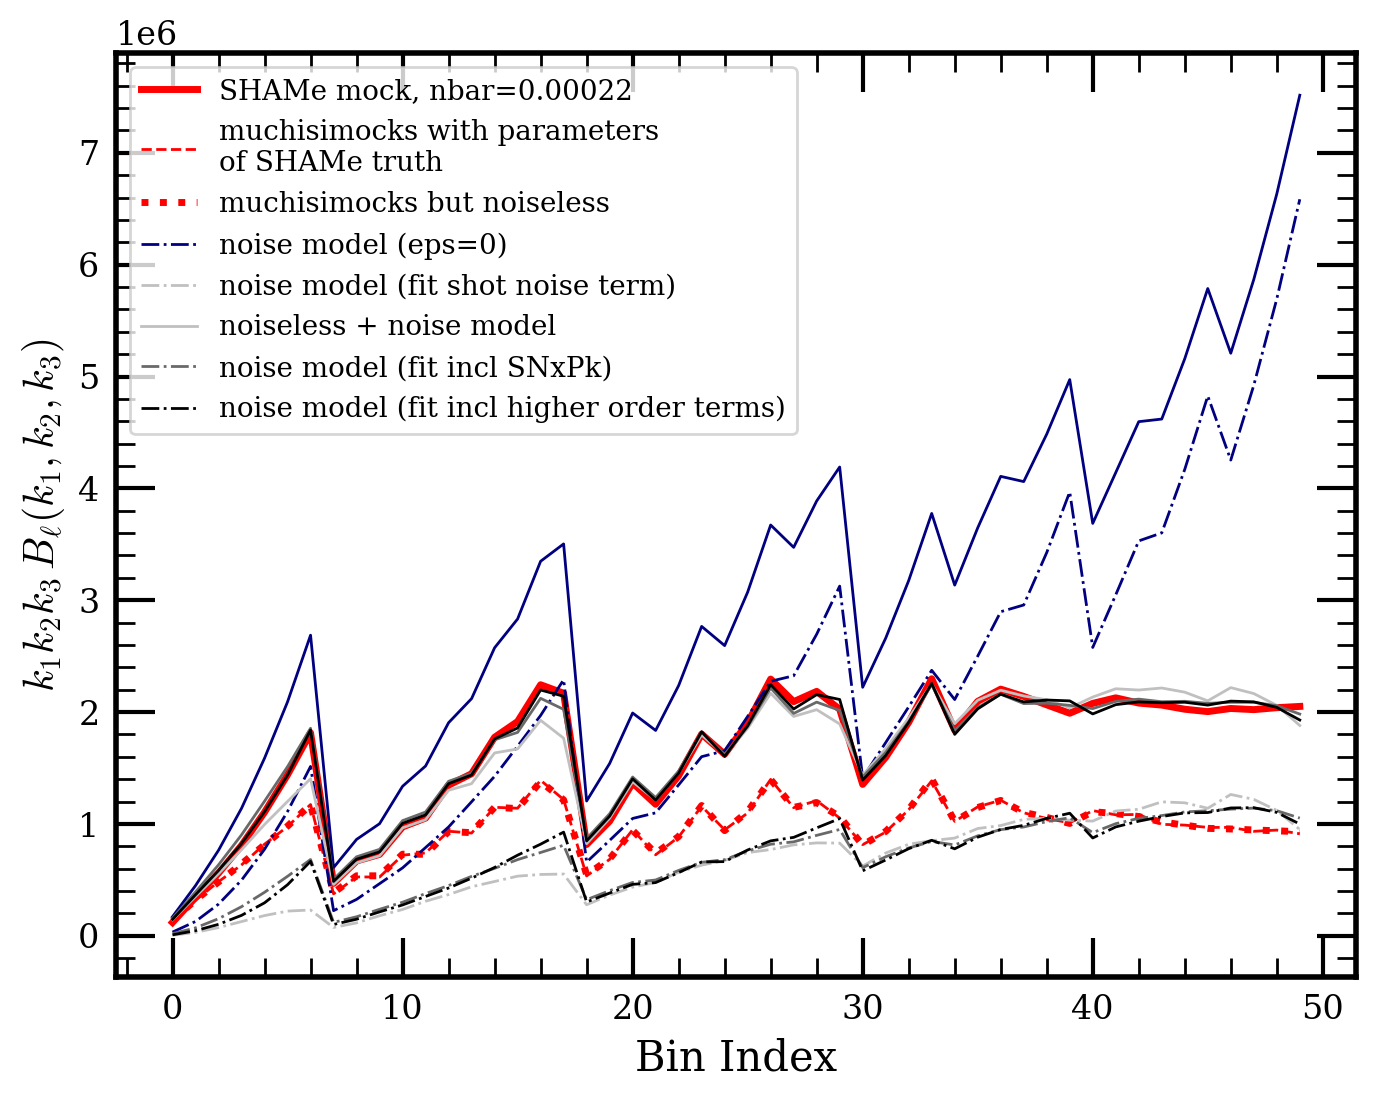

In [40]:
plt.figure(figsize=(8,6))

# ks & norm same for all
k123 = bspec.get_ks()
weight = k123.prod(axis=0)

norm = n_grid**3
norm_mock = n_grid_mock**3
print(norm, norm_mock)

i = 1
k_mock = k_mock_arr[i]
y_mock = y_mock_arr[i]

bk_corr = bk_corr_arr[i]

label = f'SHAMe mock, nbar={tag_mock.split("nbar")[-1]}'
label_muchisimocks = 'muchisimocks with parameters\nof SHAMe truth'
label_muchisimocks_noiseless = 'muchisimocks but noiseless'

plt.plot(y_mock[1], color=colors[i], label=label)
plt.plot(norm**3 * weight*bk_corr['b0'], color=colors[i], ls='--', lw=1, label=label_muchisimocks)
plt.plot(norm**3 * weight*bk_corr_noiseless_arr[i]['b0'], color=colors[i], lw=2.5, ls=':', label=label_muchisimocks_noiseless)


plt.plot(norm**3 * weight*bispec_noise0s, color='navy', ls='-.', lw=1,
         label='noise model (eps=0)')
plt.plot(norm**3 * weight*(bk_corr_noiseless_arr[i]['b0']+bispec_noise0s),
         color='navy', ls='-', lw=1, 
         #label='noiseless + noise model (fit incl higher order terms)'
         )

plt.plot(norm**3 * weight*fit_term0['model_bispectrum'], color='silver', ls='-.', lw=1,
         label='noise model (fit shot noise term)')
plt.plot(norm**3 * weight*(bk_corr_noiseless_arr[i]['b0']+fit_term0['model_bispectrum']), 
         color='silver', ls='-', lw=1, 
         label='noiseless + noise model')

plt.plot(norm**3 * weight*fit_term01['model_bispectrum'], color='dimgrey', ls='-.', lw=1,
         label='noise model (fit incl SNxPk)')
plt.plot(norm**3 * weight*(bk_corr_noiseless_arr[i]['b0']+fit_term01['model_bispectrum']),
         color='dimgrey', ls='-', lw=1, 
         #label='noiseless + noise model (fit incl SNxPk)'
         )

plt.plot(norm**3 * weight*fit_termsall['model_bispectrum'], color='black', ls='-.', lw=1,
         label='noise model (fit incl higher order terms)')
plt.plot(norm**3 * weight*(bk_corr_noiseless_arr[i]['b0']+fit_termsall['model_bispectrum']),
         color='black', ls='-', lw=1, 
         #label='noiseless + noise model (fit incl higher order terms)'
         )



#plt.plot(norm**3 * weight*bispec_noise, color='grey', ls='-.', lw=2, label='bispectrum noise model')

plt.xlabel(r'Bin Index',fontsize=15)
plt.ylabel(r'$k_1k_2k_3\,B_\ell(k_1,k_2,k_3)$',fontsize=15)
plt.legend(fontsize=10)
        

## Try Rubira & Schmidt approach

In [3]:
data_mode_test = 'shame'
tag_mock = '_nbar0.00022'
tag_data_train = None # this is used for mask; we get it below 
statistics = ['pk', 'bispec']
k_mock, y_mock, y_err_mock = data_loader.load_data_ood(data_mode_test, statistics, tag_mock, tag_data=tag_data_train)

Loaded pk with shape (30,)
Loaded pk data with shape (30,)
No tag_data provided, so not masking data
Loaded bispec with shape (50,)
Loaded bispec data with shape (50,)
No tag_data provided, so not masking data


In [4]:
dir_mocks = f'/scratch/kstoreyf/muchisimocks/muchisimocks_lib_ood/shame'
subdir_prefix = 'mock'
idx_mock = 0
fn_fields = f'{dir_mocks}/{subdir_prefix}{idx_mock}/bias_fields_eul_deconvolved_{idx_mock}.npy'
bias_terms_eul = np.load(fn_fields)

In [5]:
param_dict = data_loader.load_params_ood('shame', tag_mock)
cosmo = utils.get_cosmo(param_dict)
bias_vector = [param_dict[name] for name in utils.biasparam_names_ordered]

In [6]:
bias_vector

[0.47410742, 0.03175373, -0.16940883, -0.82443643]

In [7]:
n_grid = 128
rng = np.random.default_rng(seed=42)
noise_field_unit = rng.standard_normal((n_grid, n_grid, n_grid))

In [8]:
n_grid_orig = 512
bs = np.concatenate(([1.0], bias_vector))
tracer_field_ff_det = np.sum([bs[i] * bias_terms_eul[i] for i in range(len(bs))], axis=0) / n_grid_orig**3

In [9]:
#As_noise = [0.8, 0.5, 0.0, 0.0, 0.0]  # A_noise parameters
As_noise = bs * 1.0
tracer_field_ff_noise = np.sum([As_noise[i] * noise_field_unit * bias_terms_eul[i] for i in range(len(As_noise))], axis=0) / n_grid_orig**3

In [10]:
tracer_field_ff = tracer_field_ff_det + tracer_field_ff_noise

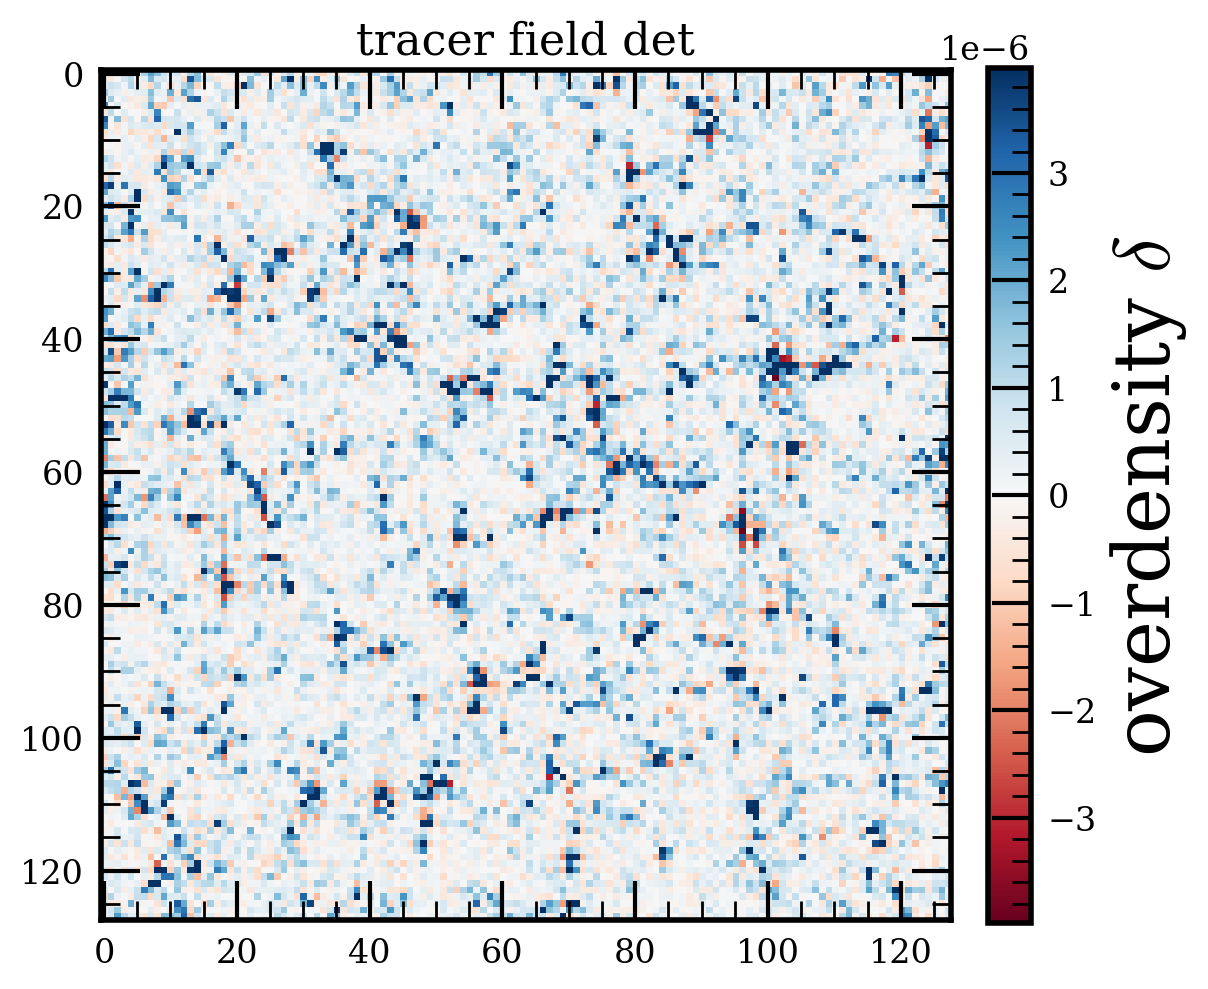

In [11]:
plotter.plot_overdensity_field(tracer_field_ff_det, title='tracer field det')

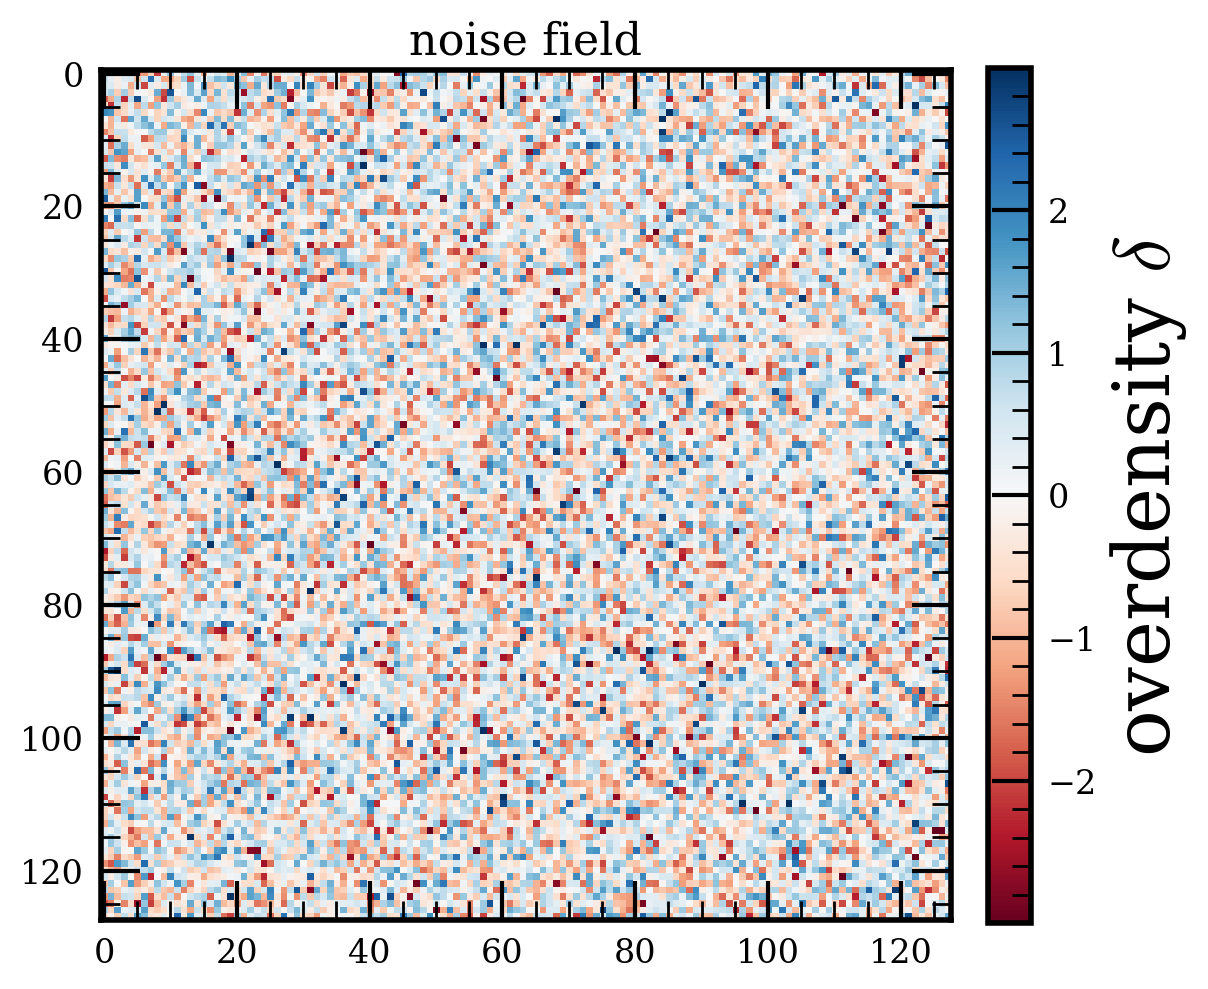

In [27]:
plotter.plot_overdensity_field(noise_field_unit, title='noise field')

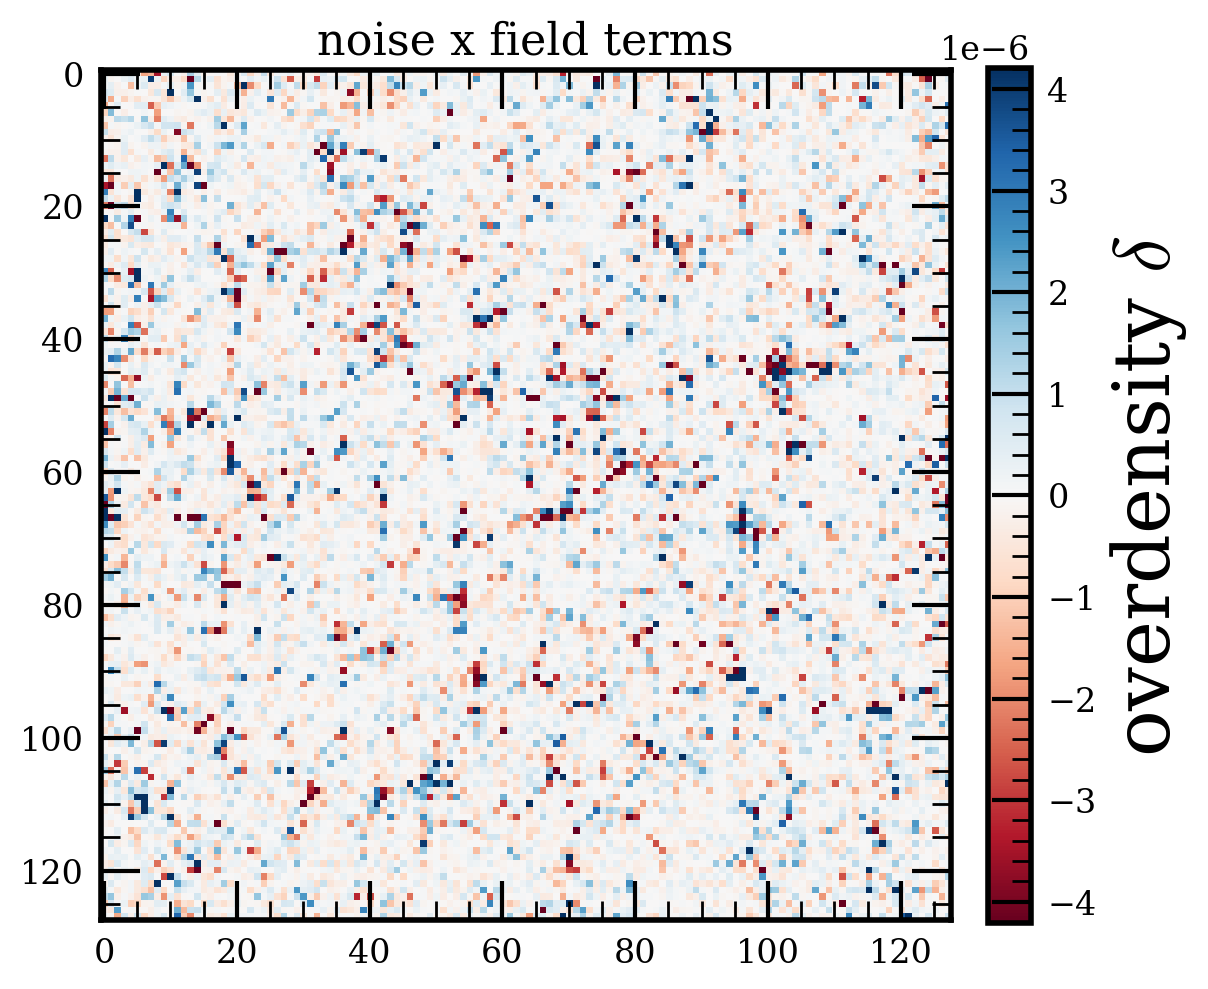

In [28]:
plotter.plot_overdensity_field(tracer_field_ff_noise, title='noise x field terms')

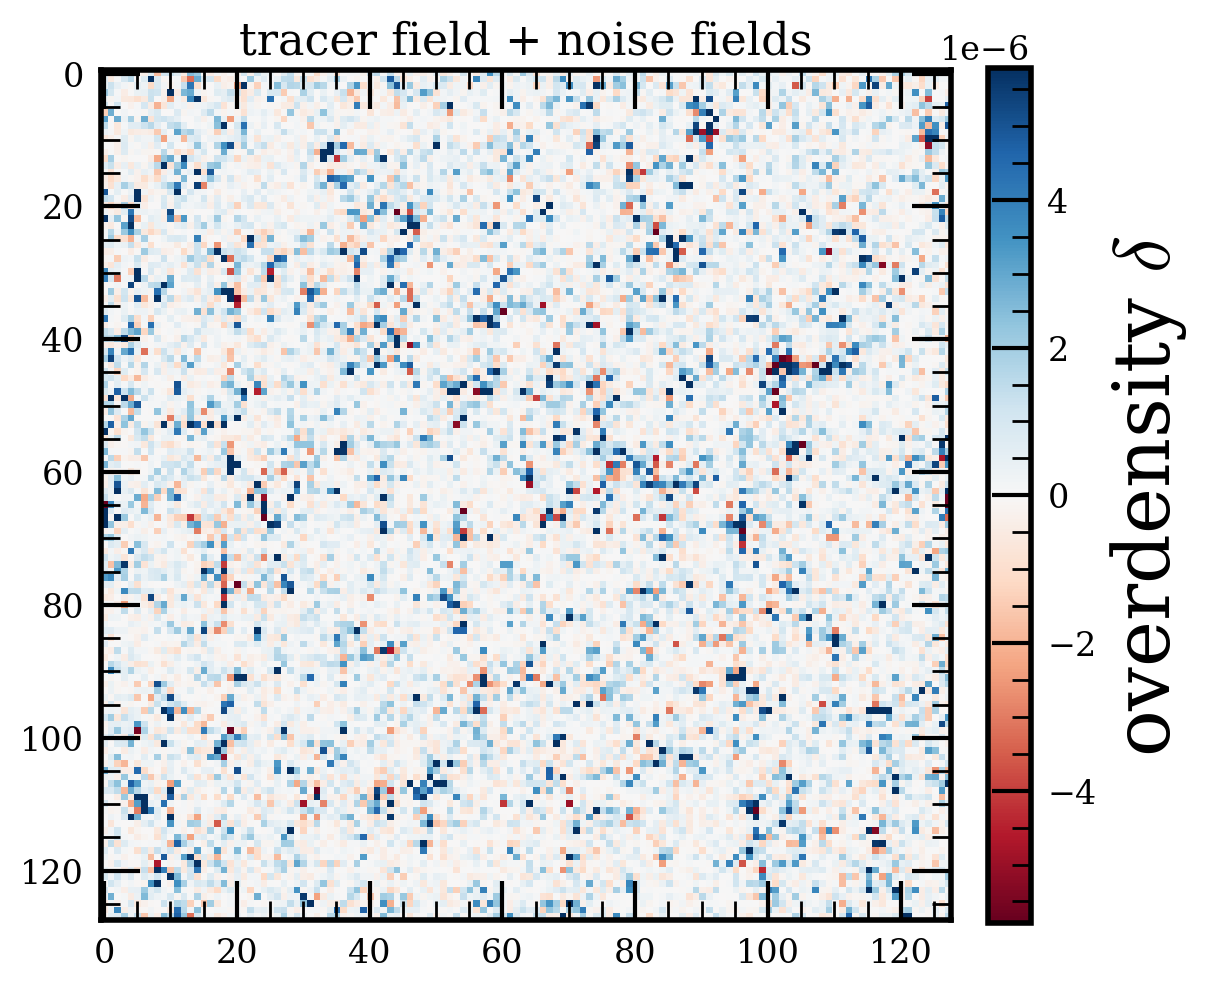

In [29]:
plotter.plot_overdensity_field(tracer_field_ff, title='tracer field + noise fields')

In [15]:
box_size = 1000.0

In [16]:
pk_obj_ff_det = cs.compute_pk(tracer_field_ff_det, cosmo, box_size,
                               n_threads=1, fn_stat=None)

Computing pk, using n_grid =  128


2025-12-01 23:39:18,005 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


2025-12-01 23:39:19,723 bacco.statistics :  ...done in 1.72 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.017226 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.043099 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000124 secs
bacco.power : Deallocating arrays


In [17]:
pk_obj_ff_noise = cs.compute_pk(tracer_field_ff_noise, cosmo, box_size,
                               n_threads=1, fn_stat=None)

Computing pk, using n_grid =  128


2025-12-01 23:39:20,128 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-12-01 23:39:20,299 bacco.statistics :  ...done in 0.171 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 0.000391988 (grid1) 0.000391988 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.014206 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.042286 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000127 secs
bacco.power : Deallocating arrays


In [18]:
pk_obj_ff = cs.compute_pk(tracer_field_ff, cosmo, box_size,
                               n_threads=1, fn_stat=None)

Computing pk, using n_grid =  128


2025-12-01 23:39:20,658 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-12-01 23:39:20,790 bacco.statistics :  ...done in 0.132 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.00039 (grid1) 1.00039 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.014111 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.042434 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000137 secs
bacco.power : Deallocating arrays


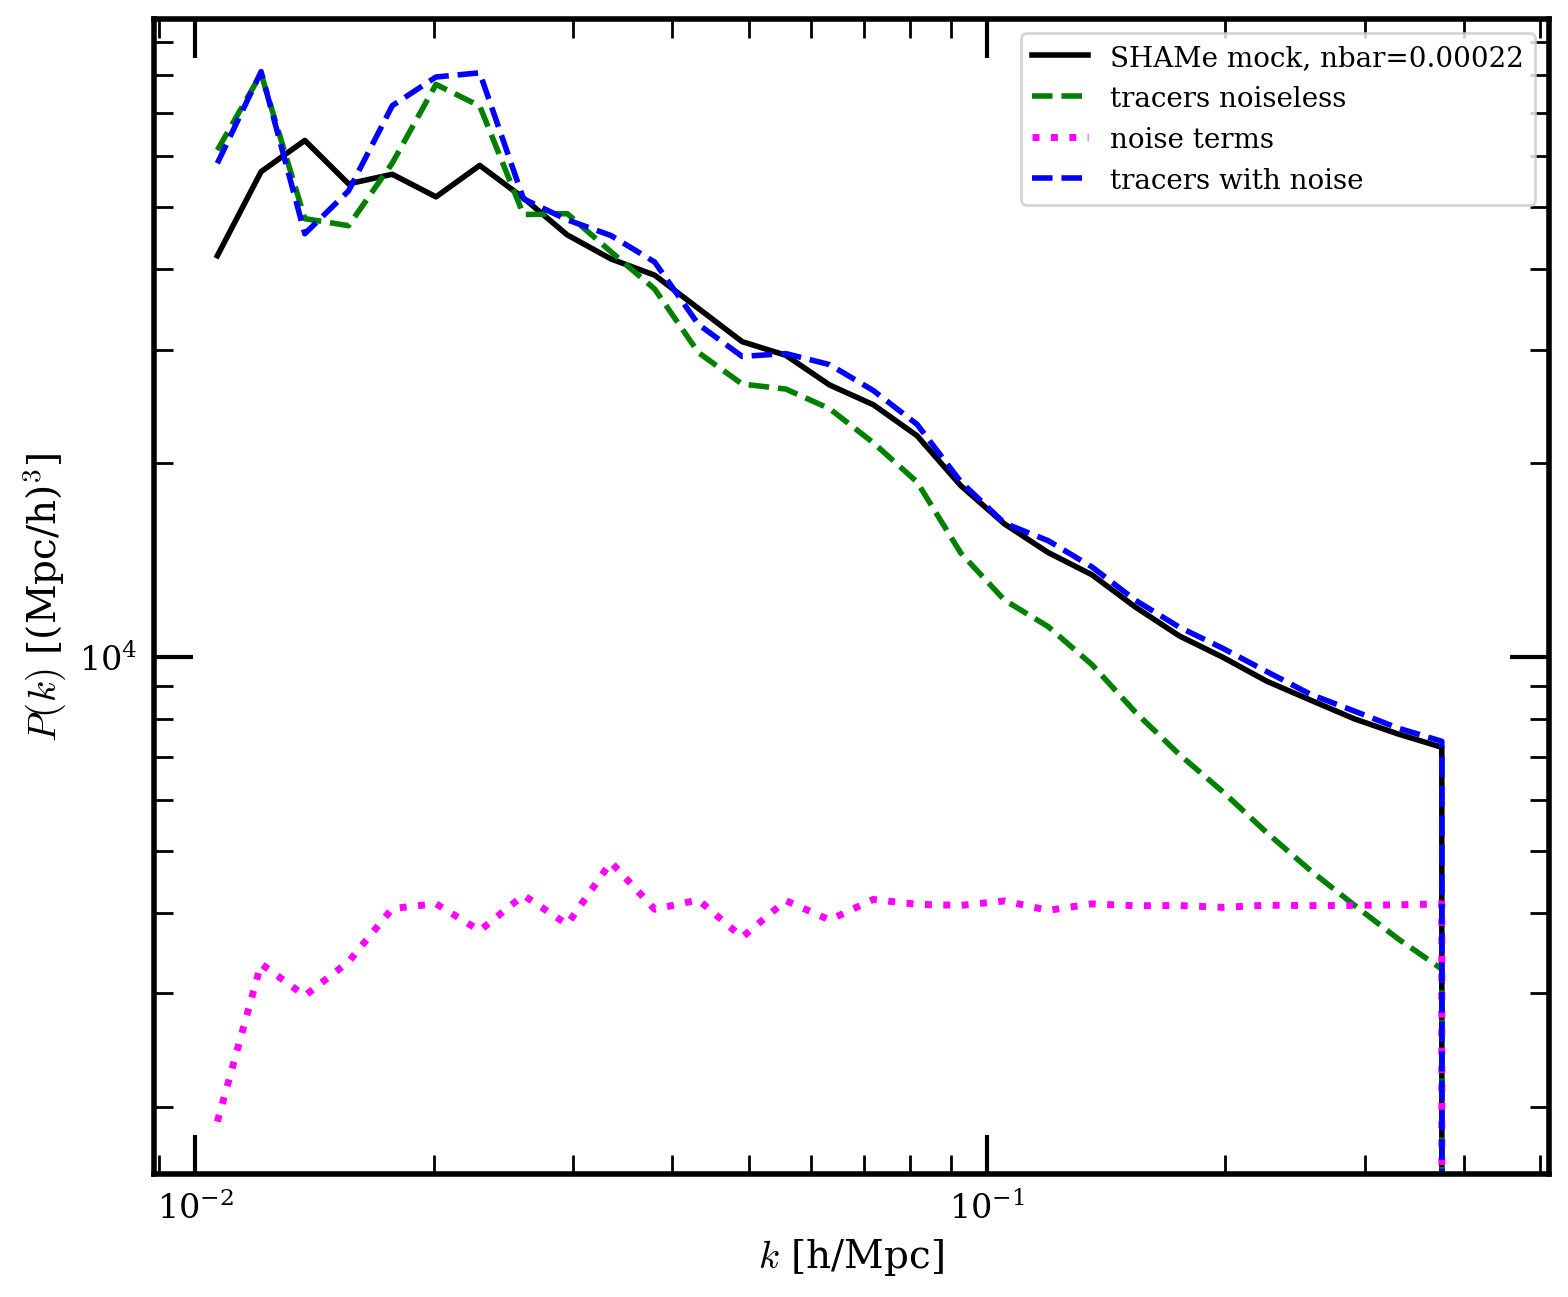

In [19]:
plt.figure(figsize=(9,7.5))
colors = ['magenta', 'red', 'orange']

label = f'SHAMe mock, nbar={tag_mock.split("nbar")[-1]}'
plt.plot(k_mock[0], y_mock[0], color='black', label=label, lw=2)

label_muchisimocks = 'muchisimocks with parameters\nof SHAMe truth'
label_noise = 'noise field'
label_noiseamp = 'estimated noise amplitude from nbar'

plt.plot(pk_obj_ff_det['k'], pk_obj_ff_det['pk'], color='green', ls='--', label='tracers noiseless', lw=2)
plt.plot(pk_obj_ff_noise['k'], pk_obj_ff_noise['pk'], ls=':', color='magenta', label='noise terms')
plt.plot(pk_obj_ff['k'], pk_obj_ff['pk'], color='blue', ls='--', label='tracers with noise', lw=2)


#plt.plot(pk_obj_pos['k'], pk_obj_pos['pk']/n_grid_mock**6, color=colors[i], label='from positions', lw=1.4, alpha=0.5)
#plt.plot(pk_obj_noiseless['k'], pk_obj_noiseless['pk'], color='grey', ls=':', label='muchisimocks but noiseless', lw=2)
#plt.fill_between(pk_obj_noiseless['k'][mask], pk_obj_noiseless['pk'][mask] - err_lo, pk_obj_noiseless['pk'][mask] + err_hi, color='grey', alpha=0.3, label=r'16-84% range, fixed cosmo test set')

plt.xscale('log')
plt.yscale('log') 
plt.xlabel(r'$k$ [h/Mpc]', fontsize=14)
plt.ylabel(r'$P(k)$ [(Mpc/h)$^3$]', fontsize=14)

plt.legend(fontsize=10, loc='upper right')

In [20]:
box_size = 1000.0
n_grid = 128

In [21]:
base = cs.setup_bispsec(box_size, n_grid, n_threads=1)


# Dimensions: [1.00e+03, 1.00e+03, 1.00e+03] Mpc/h
# Center: [0.00e+00, 0.00e+00, 0.00e+00] Mpc/h
# Line-of-sight: global
# Fourier-space grid: [128, 128, 128]
# Fundamental frequency: [0.006, 0.006, 0.006] h/Mpc
# Nyquist frequency: [0.402, 0.402, 0.402] h/Mpc
# Pixel window: none
# Using fftw backend
PolyBin3D setup time: 1.24 s


In [22]:
bspec_ff_noise, bk_corr_ff_noise = cs.compute_bispectrum(base, tracer_field_ff_noise)


Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix


In [23]:
bspec_ff_det, bk_corr_ff_det = cs.compute_bispectrum(base, tracer_field_ff_det)


Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant


Computing degeneracy factor
Computing ideal Fisher matrix


In [24]:
bspec_ff, bk_corr_ff = cs.compute_bispectrum(base, tracer_field_ff)


Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix


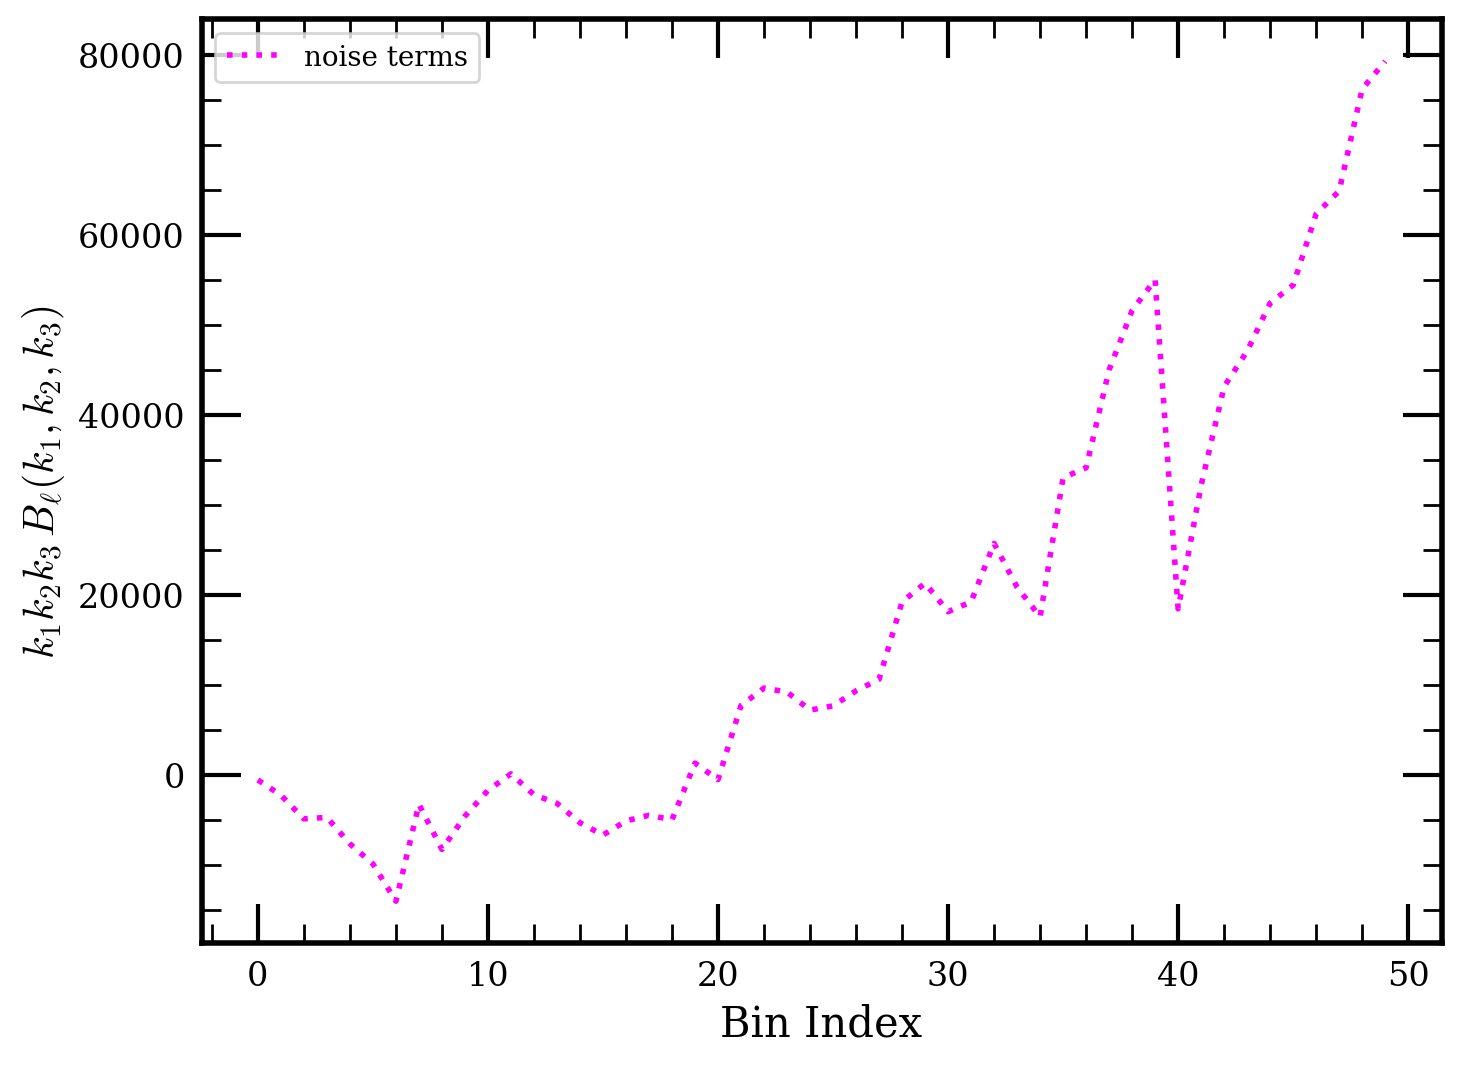

In [25]:
plt.figure(figsize=(8,6))

# ks & norm same for all
k123 = bspec_ff.get_ks()
weight = k123.prod(axis=0)

norm = n_grid**3
#norm_mock = n_grid_mock**3
#print(norm, norm_mock)

label = f'SHAMe mock, nbar={tag_mock.split("nbar")[-1]}'
label_muchisimocks = 'muchisimocks with parameters\nof SHAMe truth'
label_muchisimocks_noiseless = 'muchisimocks but noiseless'

plt.plot(norm**3 * weight*bk_corr_ff_noise['b0'], color='magenta', ls=':', lw=2, label='noise terms')

plt.xlabel(r'Bin Index',fontsize=15)
plt.ylabel(r'$k_1k_2k_3\,B_\ell(k_1,k_2,k_3)$',fontsize=15)
plt.legend(fontsize=10)
        

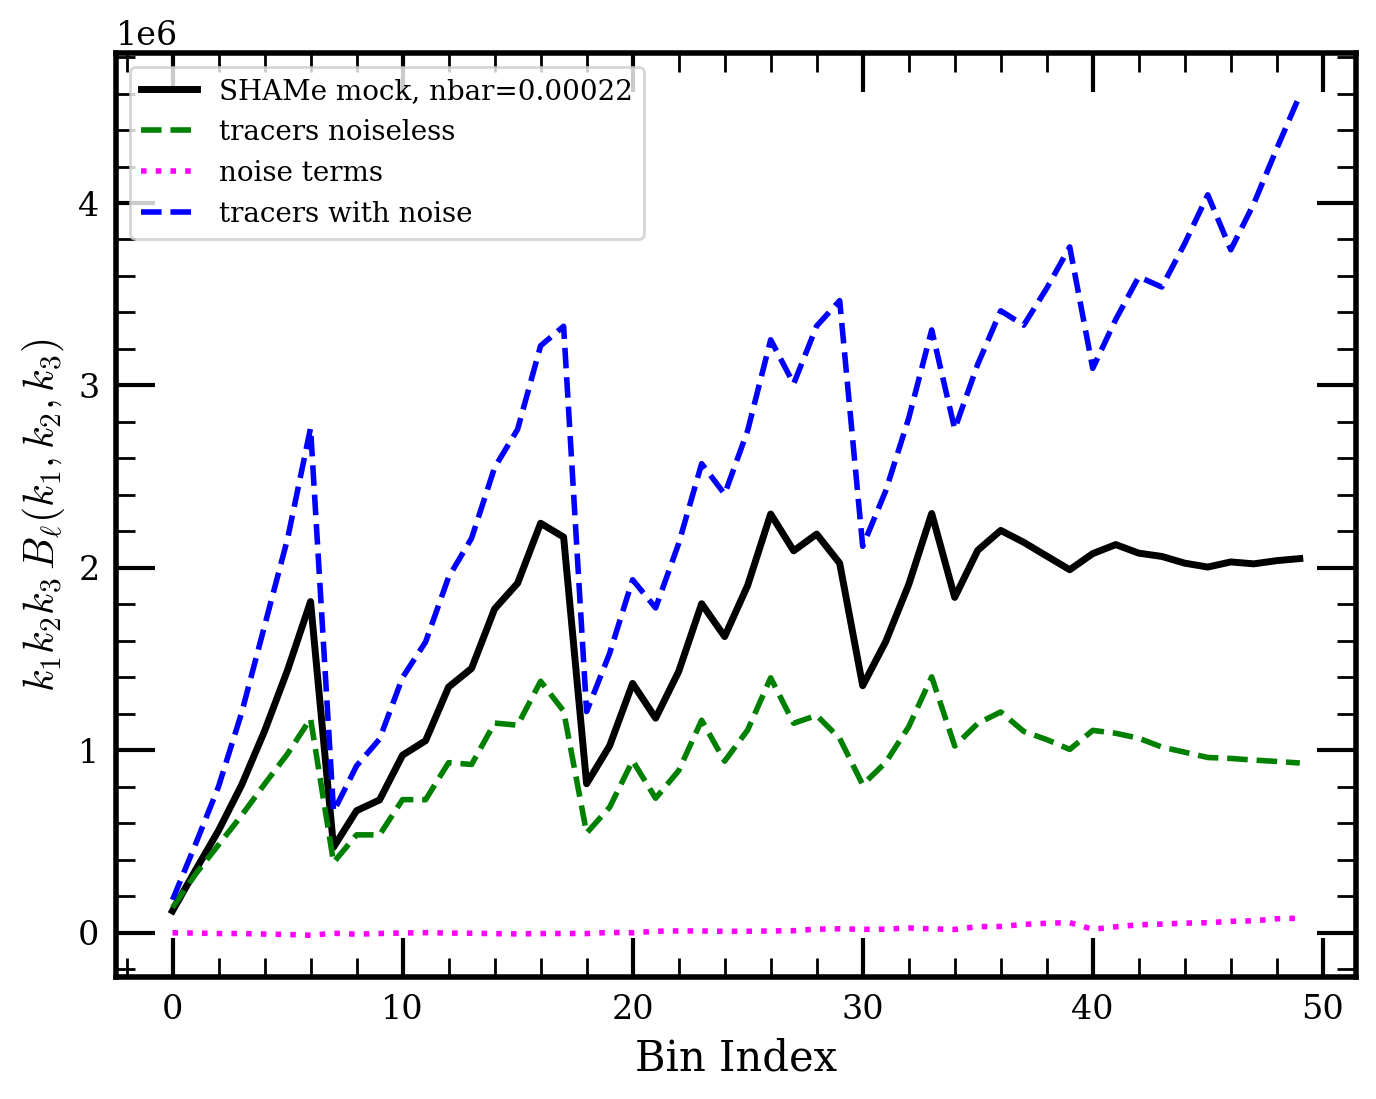

In [26]:
plt.figure(figsize=(8,6))

# ks & norm same for all
k123 = bspec_ff.get_ks()
weight = k123.prod(axis=0)

norm = n_grid**3
#norm_mock = n_grid_mock**3
#print(norm, norm_mock)

label = f'SHAMe mock, nbar={tag_mock.split("nbar")[-1]}'
label_muchisimocks = 'muchisimocks with parameters\nof SHAMe truth'
label_muchisimocks_noiseless = 'muchisimocks but noiseless'

plt.plot(y_mock[1], color='black', label=label)
plt.plot(norm**3 * weight*bk_corr_ff_det['b0'], color='green', ls='--', lw=2, label='tracers noiseless')
plt.plot(norm**3 * weight*bk_corr_ff_noise['b0'], color='magenta', ls=':', lw=2, label='noise terms')
plt.plot(norm**3 * weight*bk_corr_ff['b0'], color='blue', ls='--', lw=2, label='tracers with noise')    

plt.xlabel(r'Bin Index',fontsize=15)
plt.ylabel(r'$k_1k_2k_3\,B_\ell(k_1,k_2,k_3)$',fontsize=15)
plt.legend(fontsize=10)
        

In [25]:
import gc
gc.collect()

50893

In [30]:
nbar = float(tag_mock.split('nbar')[-1])

n_grid = 128
box_size = 1000.0  # Mpc/h
cell_size = box_size / n_grid  # Mpc/h per cell
cell_volume = cell_size**3
rms_cell = 1 / np.sqrt(nbar * cell_volume)

rng = np.random.default_rng(seed=42)

noise_field = rms_cell * rng.standard_normal((n_grid, n_grid, n_grid))
noise_field /= n_grid**3

In [31]:
tracer_field_noise_orig = tracer_field_ff + noise_field 

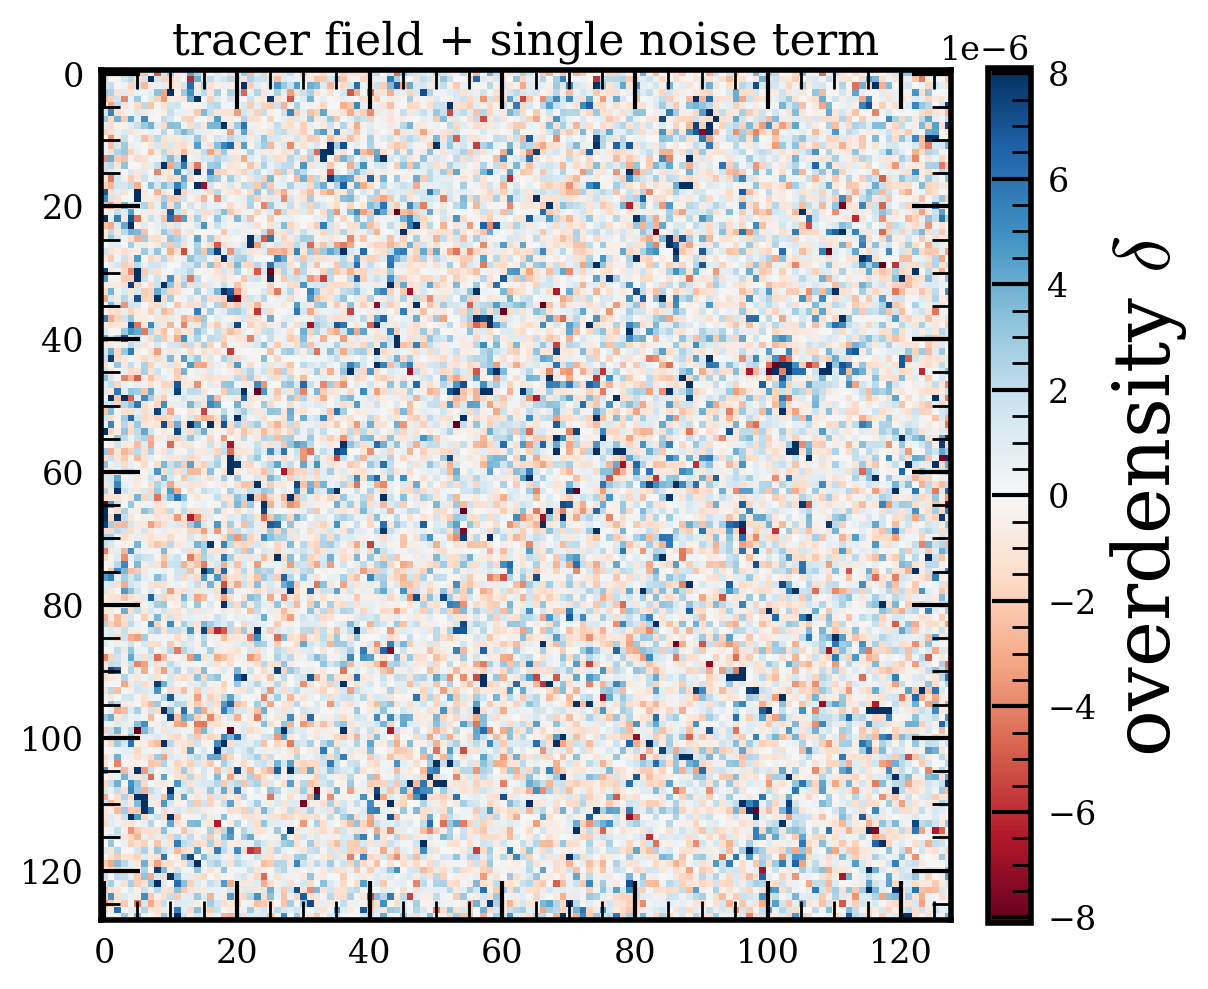

In [32]:
plotter.plot_overdensity_field(tracer_field_noise_orig, title='tracer field + single noise term')

## Mult noise implementation - np2

In [3]:
data_mode_test = 'shame'
tag_mock = '_nbar0.00022'
tag_data_train = None # this is used for mask; we get it below 
statistics = ['pk', 'bispec']
k_mock, y_mock, y_err_mock = data_loader.load_data_ood(data_mode_test, statistics, tag_mock, tag_data=tag_data_train)

Loaded pk with shape (30,)
Loaded pk data with shape (30,)
No tag_data provided, so not masking data
Loaded bispec with shape (50,)
Loaded bispec data with shape (50,)
No tag_data provided, so not masking data


In [4]:
dir_mocks = f'/scratch/kstoreyf/muchisimocks/muchisimocks_lib_ood/shame'
subdir_prefix = 'mock'
idx_mock = 0
fn_fields = f'{dir_mocks}/{subdir_prefix}{idx_mock}/bias_fields_eul_deconvolved_{idx_mock}.npy'
bias_terms_eul = np.load(fn_fields)

In [5]:
param_dict = data_loader.load_params_ood('shame', tag_mock)
cosmo = utils.get_cosmo(param_dict)
bias_vector = [param_dict[name] for name in utils.biasparam_names_ordered]

In [6]:
n_grid = 128
rng = np.random.default_rng(seed=42)
noise_field_unit = rng.standard_normal((n_grid, n_grid, n_grid))

In [8]:
n_grid_orig = 512
#A_noise_arr = [-1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0]
A_noise_arr = [[0.0, 0.0], [0.0, 1.0], [1.0, 0.0], [1.0, 1.0], [1.0, 2.0], [2.0, 1.0], [2.0, 2.0]]
tracer_field_arr = []
for A_noise in A_noise_arr:
    
    A_noise_vec = A_noise + [0.0, 0.0, 0.0] # pad to match bias terms length
    tracer_field = utils.get_tracer_field(bias_terms_eul, bias_vector,
                                                noise_field=noise_field_unit, A_noise=A_noise_vec, n_grid_norm=n_grid_orig)
    tracer_field_arr.append(tracer_field)

In [9]:
box_size = 1000.0
pk_arr = []
for i, A_noise in enumerate(A_noise_arr):
    pk = cs.compute_pk(tracer_field_arr[i], cosmo, box_size,
                                n_threads=1, fn_stat=None)
    pk_arr.append(pk)

Computing pk, using n_grid =  128


2025-12-09 19:25:28,893 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-12-09 19:25:30,475 bacco.statistics :  ...done in 1.58 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.018511 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041911 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000123 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2025-12-09 19:25:30,476 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-12-09 19:25:30,548 bacco.statistics :  ...done in 0.0719 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 0.999775 (grid1) 0.999775 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013487 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041457 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000124 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2025-12-09 19:25:30,549 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2025-12-09 19:25:30,624 bacco.statistics :  ...done in 0.0752 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.00047 (grid1) 1.00047 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.014301 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.042734 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000132 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2025-12-09 19:25:30,625 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.00024 (grid1) 1.00024 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013717 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.042240 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000128 secs
bacco.power : Deallocating arrays


2025-12-09 19:25:30,707 bacco.statistics :  ...done in 0.0819 s


Computing pk, using n_grid =  128


2025-12-09 19:25:30,707 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.00002 (grid1) 1.00002 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013802 sec
bacco.power : Counting modes


2025-12-09 19:25:30,790 bacco.statistics :  ...done in 0.0827 s


bacco.power : done counting modes in 0.041986 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000128 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2025-12-09 19:25:30,791 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.00071 (grid1) 1.00071 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013730 sec
bacco.power : Counting modes


2025-12-09 19:25:30,871 bacco.statistics :  ...done in 0.0798 s


bacco.power : done counting modes in 0.042192 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000126 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2025-12-09 19:25:30,871 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.00048 (grid1) 1.00048 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013727 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041757 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000128 secs
bacco.power : Deallocating arrays


2025-12-09 19:25:30,946 bacco.statistics :  ...done in 0.0746 s


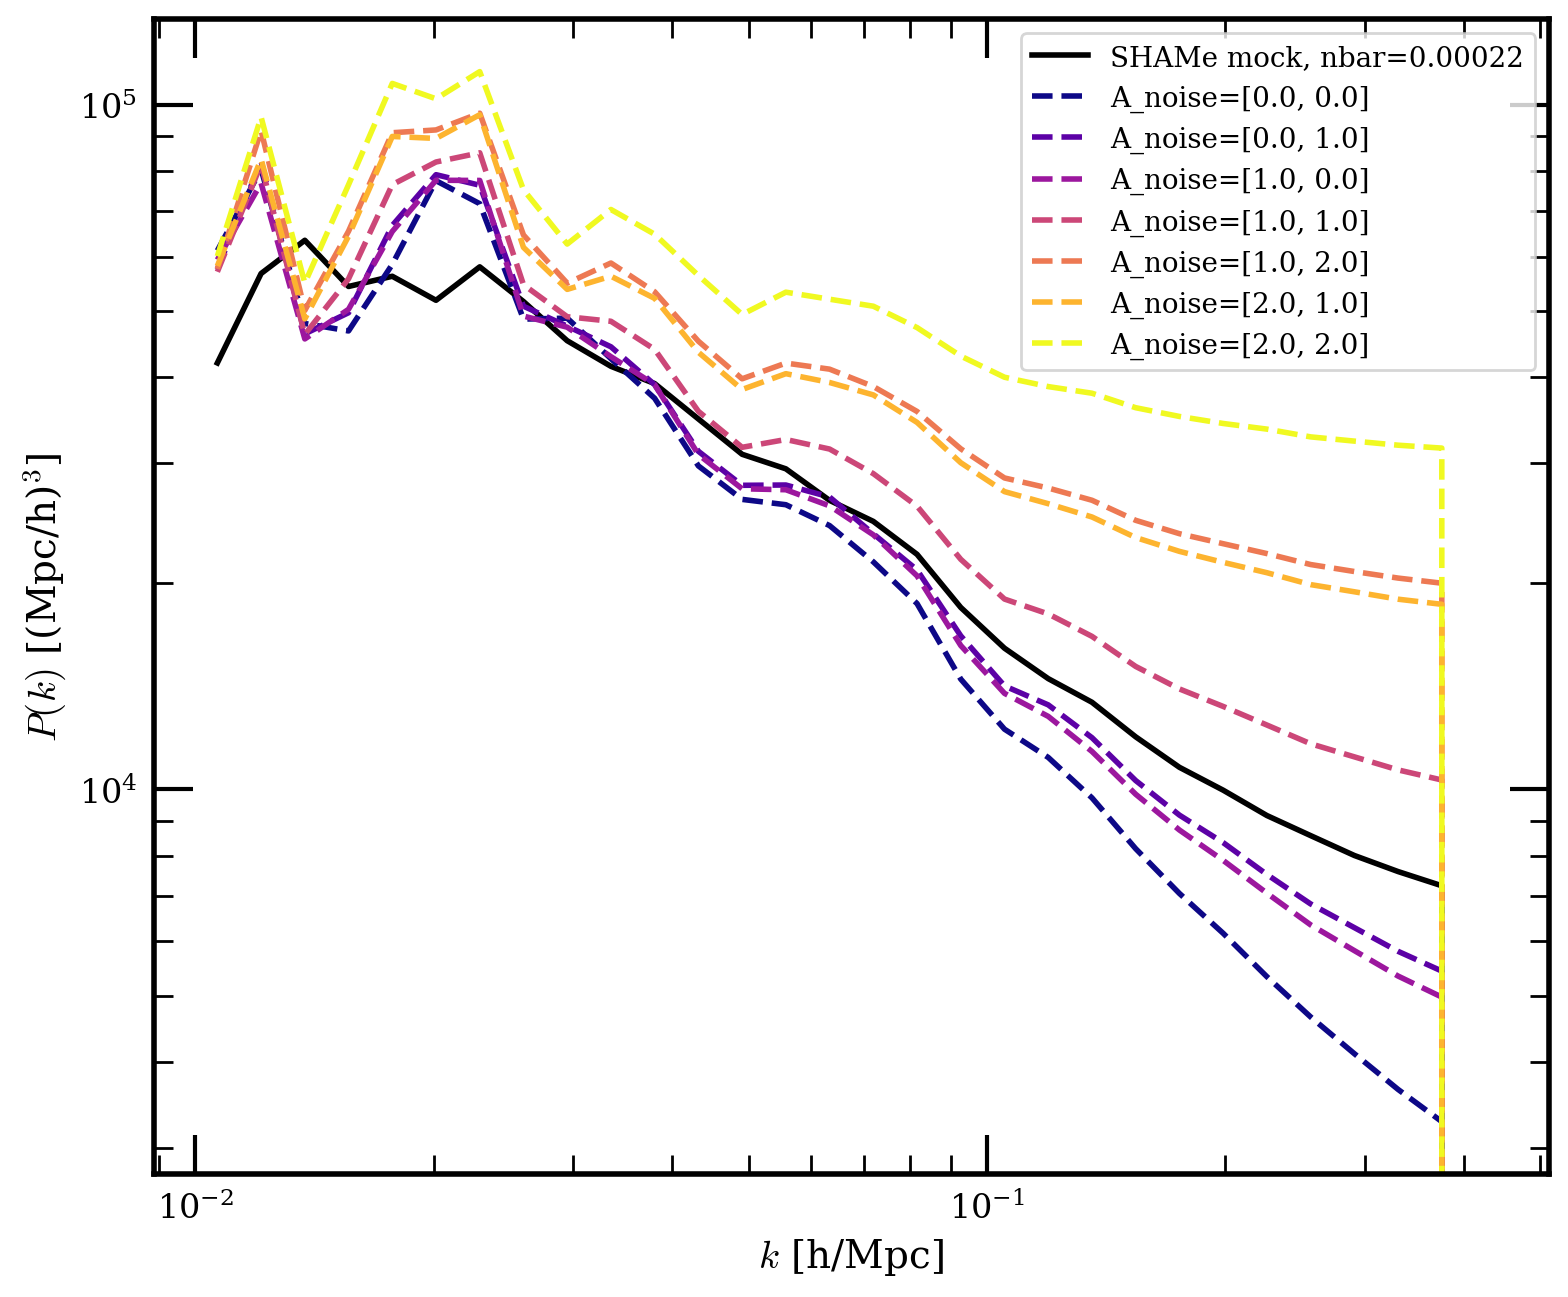

In [10]:
plt.figure(figsize=(9,7.5))
#colors = ['magenta', 'red', 'orange', 'yellow']
colors = plt.cm.plasma(np.linspace(0, 1, len(A_noise_arr)))

label = f'SHAMe mock, nbar={tag_mock.split("nbar")[-1]}'
plt.plot(k_mock[0], y_mock[0], color='black', label=label, lw=2)

for i, A_noise in enumerate(A_noise_arr):
    pk_obj = pk_arr[i]
    plt.plot(pk_obj['k'], pk_obj['pk'], color=colors[i], ls='--', label=f'A_noise={A_noise}', lw=2)

plt.xscale('log')
plt.yscale('log') 
plt.xlabel(r'$k$ [h/Mpc]', fontsize=14)
plt.ylabel(r'$P(k)$ [(Mpc/h)$^3$]', fontsize=14)

plt.legend(fontsize=10, loc='upper right')

In [11]:
import gc
gc.collect()

2031

In [12]:
box_size = 1000.0
base = cs.setup_bispsec(box_size, n_grid, n_threads=1)


# Dimensions: [1.00e+03, 1.00e+03, 1.00e+03] Mpc/h
# Center: [0.00e+00, 0.00e+00, 0.00e+00] Mpc/h
# Line-of-sight: global
# Fourier-space grid: [128, 128, 128]
# Fundamental frequency: [0.006, 0.006, 0.006] h/Mpc
# Nyquist frequency: [0.402, 0.402, 0.402] h/Mpc
# Pixel window: none
# Using fftw backend
PolyBin3D setup time: 0.19 s


In [13]:
bspec_arr, bk_corr_arr = [], []
for i, A_noise in enumerate(A_noise_arr):
    bspec, bk_corr = cs.compute_bispectrum(base, tracer_field_arr[i])
    bspec_arr.append(bspec)
    bk_corr_arr.append(bk_corr)


Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix



Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix


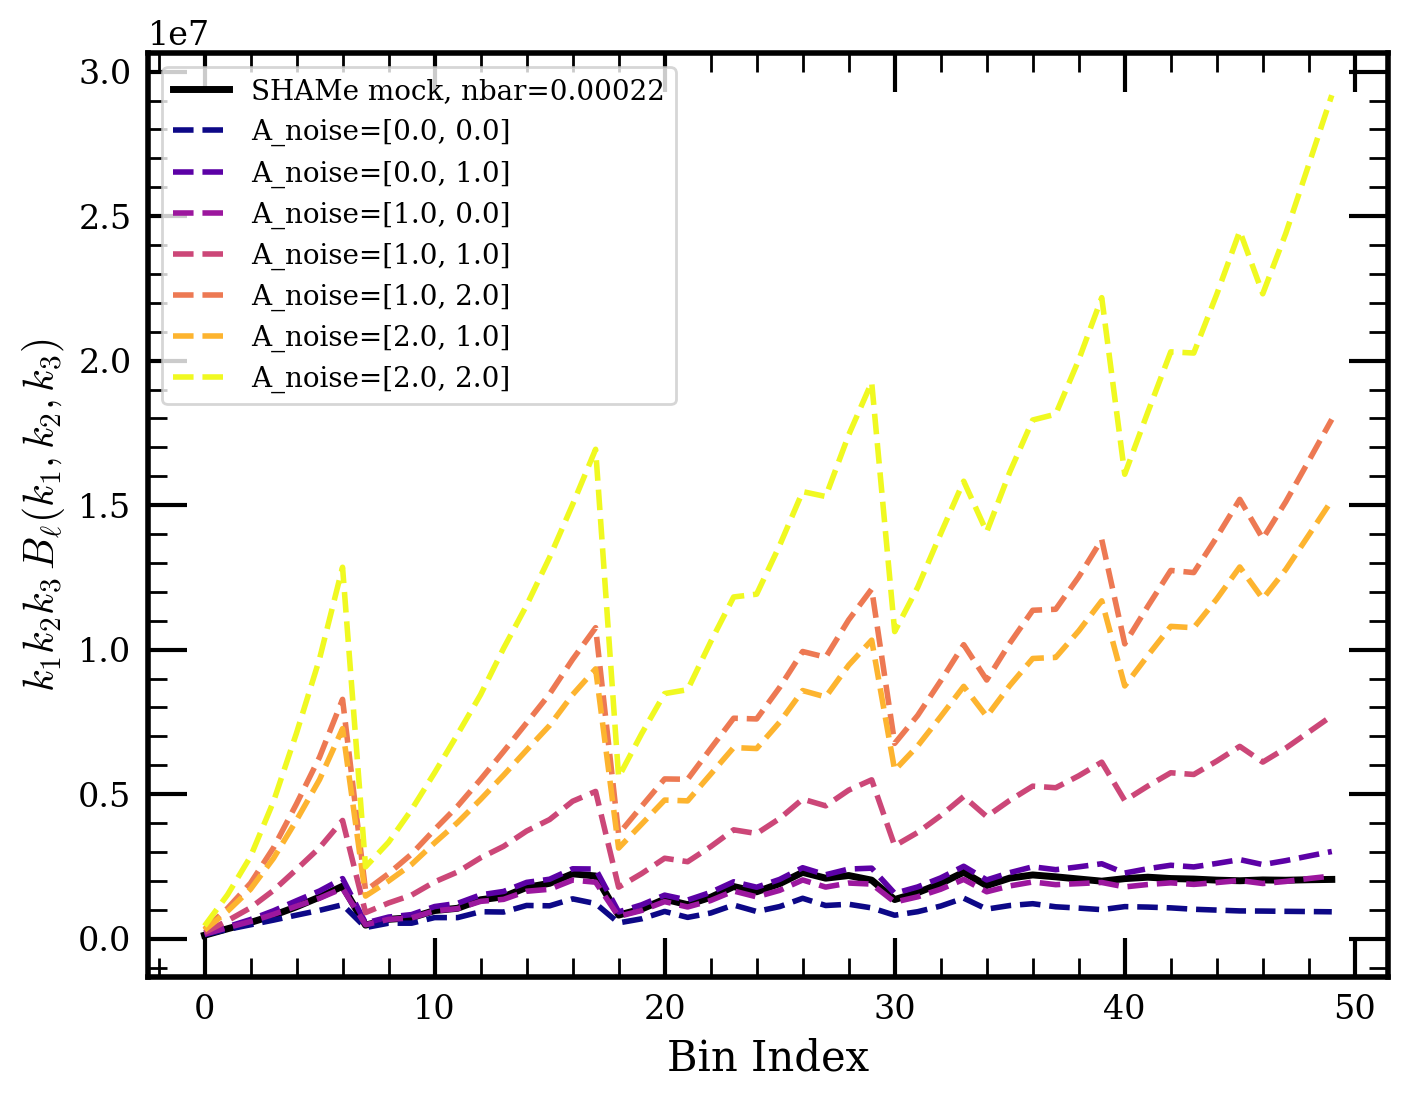

In [14]:
plt.figure(figsize=(8,6))

# ks & norm same for all
k123 = bspec_arr[0].get_ks()
weight = k123.prod(axis=0)

norm = n_grid**3
#norm_mock = n_grid_mock**3
#print(norm, norm_mock)

label = f'SHAMe mock, nbar={tag_mock.split("nbar")[-1]}'

plt.plot(y_mock[1], color='black', label=label)

for i, A_noise in enumerate(A_noise_arr):
    plt.plot(norm**3 * weight*bk_corr_arr[i]['b0'], color=colors[i], ls='--', lw=2, label=f'A_noise={A_noise}')

plt.xlabel(r'Bin Index',fontsize=15)
plt.ylabel(r'$k_1k_2k_3\,B_\ell(k_1,k_2,k_3)$',fontsize=15)
plt.legend(fontsize=10)
        

## Mult noise implementation to 2nd order

In [3]:
data_mode_test = 'shame'
tag_mock = '_nbar0.00022'
tag_data_train = None # this is used for mask; we get it below 
statistics = ['pk', 'bispec']
k_mock, y_mock, y_err_mock = data_loader.load_data_ood(data_mode_test, statistics, tag_mock, tag_data=tag_data_train)

Loaded pk with shape (30,)
Loaded pk data with shape (30,)
No tag_data provided, so not masking data
Loaded bispec with shape (50,)
Loaded bispec data with shape (50,)
No tag_data provided, so not masking data


In [4]:
dir_mocks = f'/scratch/kstoreyf/muchisimocks/muchisimocks_lib_ood/shame'
subdir_prefix = 'mock'
idx_mock = 0
fn_fields = f'{dir_mocks}/{subdir_prefix}{idx_mock}/bias_fields_eul_deconvolved_{idx_mock}.npy'
bias_terms_eul = np.load(fn_fields)

In [5]:
param_dict = data_loader.load_params_ood('shame', tag_mock)
cosmo = utils.get_cosmo(param_dict)
bias_vector = [param_dict[name] for name in utils.biasparam_names_ordered]

In [6]:
n_grid = 128
rng = np.random.default_rng(seed=42)
noise_field_unit = rng.standard_normal((n_grid, n_grid, n_grid))

In [7]:
box_size = 1000.0
n_grid_orig = 512

In [8]:
bs = np.concatenate(([1.0], bias_vector))
tracer_field_noiseless = np.sum([bs[i] * bias_terms_eul[i] for i in range(len(bs))], axis=0) / n_grid_orig**3

In [9]:
pk_noiseless = cs.compute_pk(tracer_field_noiseless, cosmo, box_size,
                                n_threads=1, fn_stat=None)

Computing pk, using n_grid =  128


2026-01-06 23:08:38,369 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


2026-01-06 23:08:39,923 bacco.statistics :  ...done in 1.55 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.016249 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.043906 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000129 secs
bacco.power : Deallocating arrays


In [10]:
import gc
gc.collect()

0

In [11]:
box_size = 1000.0
base = cs.setup_bispsec(box_size, n_grid, n_threads=1)


# Dimensions: [1.00e+03, 1.00e+03, 1.00e+03] Mpc/h
# Center: [0.00e+00, 0.00e+00, 0.00e+00] Mpc/h
# Line-of-sight: global
# Fourier-space grid: [128, 128, 128]
# Fundamental frequency: [0.006, 0.006, 0.006] h/Mpc
# Nyquist frequency: [0.402, 0.402, 0.402] h/Mpc
# Pixel window: none
# Using fftw backend
PolyBin3D setup time: 0.19 s


In [12]:
bspec_noiseless, bk_corr_noiseless  = cs.compute_bispectrum(base, tracer_field_noiseless)


Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix


### Investigate by hand

In [23]:
n_grid_orig = 512
#A_noise_arr = [-1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0]
bs = [1.0] + list(bias_vector)
A_noise_arr = [[0.0, 0.0, 0.5, 0.5, 8.0]]
A2_noise_arr = [[0.15, 0.0, 0.0, 0.0, 0.0]]
# A_noise_arr = [[0.0, 0.0, 0.5, 0.0, 10.0]]
# A2_noise_arr = [[0.15, 0.2, 0.0, 0.0, 0.0]]
tracer_field_arr = []
for aa in range(len(A_noise_arr)):
    As_noise = A_noise_arr[aa]
    A2s_noise = A2_noise_arr[aa]
    
    tracer_field_noise = np.sum([As_noise[i] * noise_field_unit * bias_terms_eul[i] for i in range(len(As_noise))], axis=0) / n_grid_orig**3
    tracer_field_noise2 = np.sum([A2s_noise[i] * noise_field_unit**2 * bias_terms_eul[i] for i in range(len(A2s_noise))], axis=0) / n_grid_orig**3
    tracer_field = tracer_field_noiseless + tracer_field_noise + tracer_field_noise2
    #A_noise_vec = A_noise + [0.0, 0.0, 0.0] # pad to match bias terms length
    # tracer_field = utils.get_tracer_field(bias_terms_eul, bias_vector,
    #                                             noise_field=noise_field_unit, A_noise=A_noise_vec, n_grid_norm=n_grid_orig)
    tracer_field_arr.append(tracer_field)

In [377]:
box_size = 1000.0
pk_arr = []
for i, A_noise in enumerate(A_noise_arr):
    pk = cs.compute_pk(tracer_field_arr[i], cosmo, box_size,
                                n_threads=1, fn_stat=None)
    pk_arr.append(pk)

Computing pk, using n_grid =  128


2026-01-06 08:12:50,496 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-01-06 08:12:50,562 bacco.statistics :  ...done in 0.0665 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.14961 (grid1) 1.14961 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013414 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041729 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000123 secs
bacco.power : Deallocating arrays


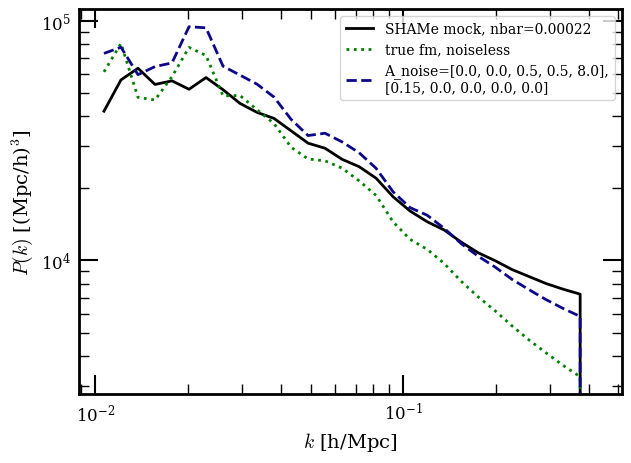

In [378]:
plt.figure(figsize=(7,5))
#colors = ['magenta', 'red', 'orange', 'yellow']
colors = plt.cm.plasma(np.linspace(0, 1, len(A_noise_arr)))

label = f'SHAMe mock, nbar={tag_mock.split("nbar")[-1]}'
plt.plot(k_mock[0], y_mock[0], color='black', label=label, lw=2)
plt.plot(pk_noiseless['k'], pk_noiseless['pk'], color='green', ls=':', label='true fm, noiseless', lw=2)

for i, A_noise in enumerate(A_noise_arr):
    pk_obj = pk_arr[i]
    plt.plot(pk_obj['k'], pk_obj['pk'], color=colors[i], ls='--', label=f'A_noise={A_noise},\n{A2_noise_arr[i]}', lw=2)

plt.xscale('log')
plt.yscale('log') 
plt.xlabel(r'$k$ [h/Mpc]', fontsize=14)
plt.ylabel(r'$P(k)$ [(Mpc/h)$^3$]', fontsize=14)

plt.legend(fontsize=10, loc='upper right')

In [379]:
bspec_arr, bk_corr_arr = [], []
for i, A_noise in enumerate(A_noise_arr):
    bspec, bk_corr = cs.compute_bispectrum(base, tracer_field_arr[i])
    bspec_arr.append(bspec)
    bk_corr_arr.append(bk_corr)


Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix


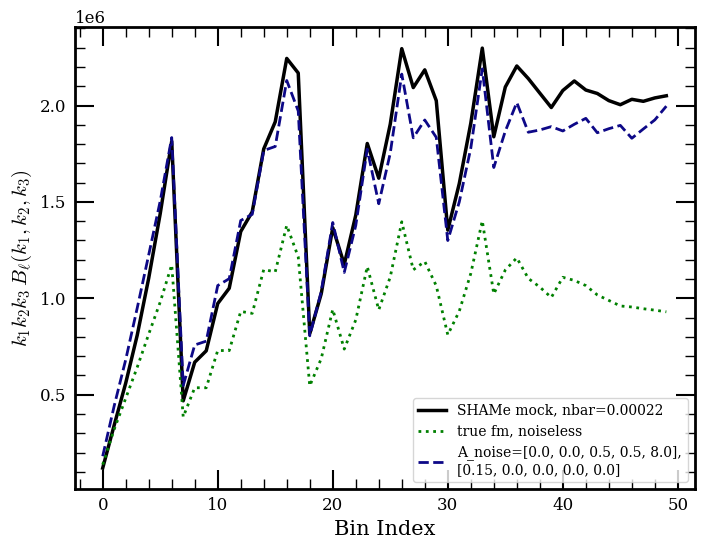

In [380]:
plt.figure(figsize=(8,6))

# ks & norm same for all
k123 = bspec_arr[0].get_ks()
weight = k123.prod(axis=0)

norm = n_grid**3
#norm_mock = n_grid_mock**3
#print(norm, norm_mock)

label = f'SHAMe mock, nbar={tag_mock.split("nbar")[-1]}'

plt.plot(y_mock[1], color='black', label=label)
plt.plot(norm**3 * weight*bk_corr_noiseless['b0'], color='green', ls=':', label='true fm, noiseless', lw=2)

for i, A_noise in enumerate(A_noise_arr):
    plt.plot(norm**3 * weight*bk_corr_arr[i]['b0'], color=colors[i], ls='--', lw=2, label=f'A_noise={A_noise},\n{A2_noise_arr[i]}')

plt.xlabel(r'Bin Index',fontsize=15)
plt.ylabel(r'$k_1k_2k_3\,B_\ell(k_1,k_2,k_3)$',fontsize=15)
plt.legend(fontsize=10)
        

### Look at each Anoise parameter dependence

In [13]:
## Vary A_noise and A2_noise parameters - Compute

# Set parameter ranges for each of the 10 parameters individually
# First 5 are for A_noise[0] through A_noise[4], last 5 are for A2_noise[0] through A2_noise[4]
# Format: [[min, max], [min, max], ...] for each parameter
param_ranges_A = [
    [0.0, 2.0],   # A_noise[0]
    [0.0, 2.0],   # A_noise[1]
    [0.0, 2.0],   # A_noise[2]
    [0.0, 2.0],   # A_noise[3]
    [0.0, 20.0],  # A_noise[4]
]
param_ranges_A2 = [
    [0.0, 0.5],   # A2_noise[0]
    [0.0, 0.5],   # A2_noise[1]
    [0.0, 0.5],   # A2_noise[2]
    [0.0, 0.5],   # A2_noise[3]
    [0.0, 5.0]    # A2_noise[4]
]

n_Abins = 2

# Create evenly spaced parameter values for the parameters
A_noise_vals = [np.linspace(param_ranges_A[i][0], param_ranges_A[i][1], n_Abins) for i in range(len(param_ranges_A))]
A2_noise_vals = [np.linspace(param_ranges_A2[i][0], param_ranges_A2[i][1], n_Abins) for i in range(len(param_ranges_A2))]    

# Set fixed values for other parameters (using midpoint of their ranges by default)
# Can override these with explicit values if desired
A_noise_fixed = [0, 0, 0, 0, 0]
A2_noise_fixed = [0, 0, 0, 0, 0]
n_noiseparams = len(A_noise_fixed) + len(A2_noise_fixed)

In [14]:
print(A_noise_vals)
print(A2_noise_vals)

[array([0., 2.]), array([0., 2.]), array([0., 2.]), array([0., 2.]), array([ 0., 20.])]
[array([0. , 0.5]), array([0. , 0.5]), array([0. , 0.5]), array([0. , 0.5]), array([0., 5.])]


In [15]:
# Compute pk and bk for each parameter combination
pk_results_arr = []
bk_results_arr = []

n_grid_orig = 512
for i in range(n_noiseparams):
    pk_results_subarr = []
    for j in range(n_Abins):
        # Create parameter arrays (varying first element, others fixed)
        As_noise = A_noise_fixed.copy()
        A2s_noise = A2_noise_fixed.copy()
        if i < len(A_noise_fixed):
            As_noise[i] = A_noise_vals[i][j]
        else:
            A2s_noise[i - len(A_noise_fixed)] = A2_noise_vals[i - len(A_noise_fixed)][j]
        
        # Create tracer field (following cell 95 style)
        tracer_field_noise = np.sum([As_noise[ii] * noise_field_unit * bias_terms_eul[ii] 
                                        for ii in range(len(As_noise))], axis=0) / n_grid_orig**3
        tracer_field_noise2 = np.sum([A2s_noise[ii] * noise_field_unit**2 * bias_terms_eul[ii] 
                                        for ii in range(len(A2s_noise))], axis=0) / n_grid_orig**3
        tracer_field = tracer_field_noiseless + tracer_field_noise + tracer_field_noise2
        
        # Compute pk
        pk_obj = cs.compute_pk(tracer_field, cosmo, box_size, n_threads=1, fn_stat=None)
        pk_results_subarr.append({
            'As_noise': As_noise,
            'A2s_noise': A2s_noise,
            'pk': pk_obj['pk'],
            'k': pk_obj['k']
        })
        
    pk_results_arr.append(pk_results_subarr)


Computing pk, using n_grid =  128


2026-01-06 19:37:38,246 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-01-06 19:37:38,327 bacco.statistics :  ...done in 0.0811 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.014045 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.042280 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000160 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2026-01-06 19:37:38,844 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-01-06 19:37:38,911 bacco.statistics :  ...done in 0.0669 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.00093 (grid1) 1.00093 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013641 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041507 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000133 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2026-01-06 19:37:39,404 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-01-06 19:37:39,470 bacco.statistics :  ...done in 0.0663 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013517 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041330 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000124 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2026-01-06 19:37:39,829 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-01-06 19:37:39,896 bacco.statistics :  ...done in 0.0666 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 0.999551 (grid1) 0.999551 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013703 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041273 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000122 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2026-01-06 19:37:40,448 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-01-06 19:37:40,515 bacco.statistics :  ...done in 0.067 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013501 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041891 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000125 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2026-01-06 19:37:41,003 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-01-06 19:37:41,069 bacco.statistics :  ...done in 0.0668 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.00057 (grid1) 1.00057 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013525 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041679 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000124 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2026-01-06 19:37:41,530 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-01-06 19:37:41,596 bacco.statistics :  ...done in 0.0663 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013545 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041707 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000125 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2026-01-06 19:37:42,046 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-01-06 19:37:42,112 bacco.statistics :  ...done in 0.0666 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.00089 (grid1) 1.00089 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013858 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041271 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000123 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2026-01-06 19:37:42,632 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-01-06 19:37:42,698 bacco.statistics :  ...done in 0.0663 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013505 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041549 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000122 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2026-01-06 19:37:43,131 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-01-06 19:37:43,197 bacco.statistics :  ...done in 0.0668 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 0.997607 (grid1) 0.997607 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013660 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041745 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000125 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2026-01-06 19:37:43,748 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-01-06 19:37:43,814 bacco.statistics :  ...done in 0.066 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013733 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041309 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000125 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2026-01-06 19:37:44,239 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-01-06 19:37:44,306 bacco.statistics :  ...done in 0.0664 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.50066 (grid1) 1.50066 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013661 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041346 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000122 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2026-01-06 19:37:44,790 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-01-06 19:37:44,857 bacco.statistics :  ...done in 0.0669 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013622 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041921 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000122 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2026-01-06 19:37:45,281 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-01-06 19:37:45,347 bacco.statistics :  ...done in 0.066 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.00077 (grid1) 1.00077 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013591 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041512 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000120 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2026-01-06 19:37:45,942 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-01-06 19:37:46,008 bacco.statistics :  ...done in 0.0662 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013640 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041366 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000127 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2026-01-06 19:37:46,449 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-01-06 19:37:46,515 bacco.statistics :  ...done in 0.0661 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 0.998926 (grid1) 0.998926 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013634 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041276 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000124 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2026-01-06 19:37:47,012 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-01-06 19:37:47,078 bacco.statistics :  ...done in 0.066 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013632 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041308 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000123 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2026-01-06 19:37:47,474 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-01-06 19:37:47,540 bacco.statistics :  ...done in 0.0662 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 0.999399 (grid1) 0.999399 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013701 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041352 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000125 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2026-01-06 19:37:48,040 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-01-06 19:37:48,106 bacco.statistics :  ...done in 0.066 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013613 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041277 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000124 secs
bacco.power : Deallocating arrays
Computing pk, using n_grid =  128


2026-01-06 19:37:48,657 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-01-06 19:37:48,723 bacco.statistics :  ...done in 0.0662 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 0.998733 (grid1) 0.998733 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013673 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041594 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000124 secs
bacco.power : Deallocating arrays


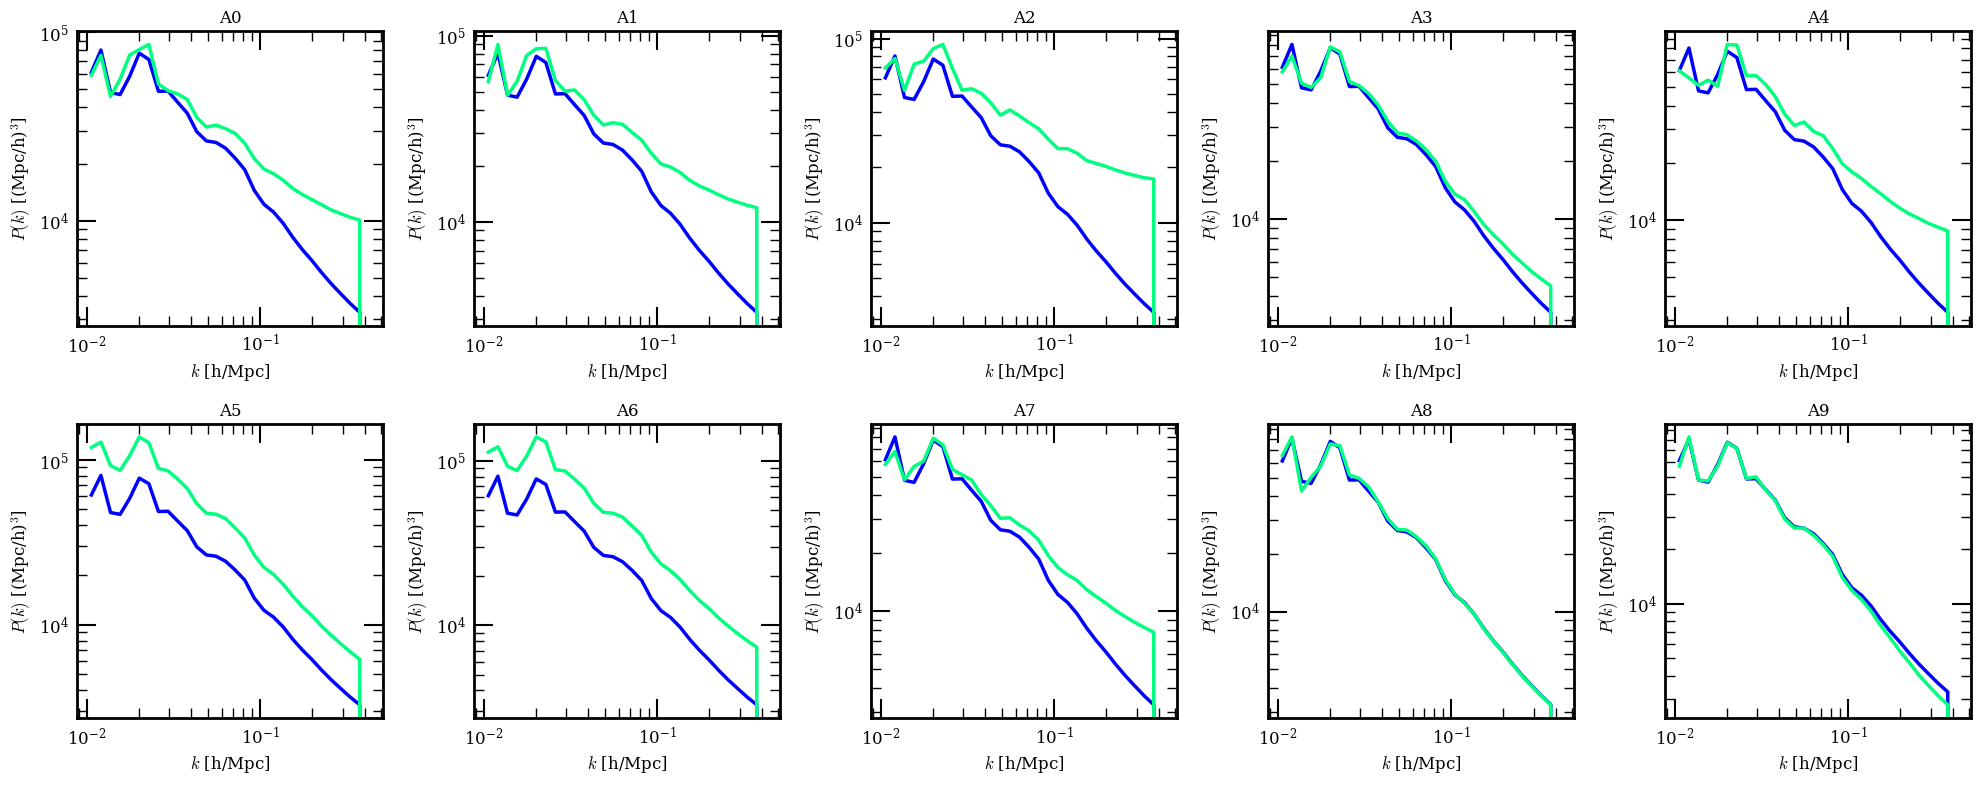

In [16]:
## Vary A_noise and A2_noise parameters - Plot

# Create grid plots: 2 rows x 5 columns
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

colors = plt.cm.winter(np.linspace(0, 1, n_Abins))

# Plot pk for different k-bins (top row)
for i in range(n_noiseparams):
    ax = axes[i]
    # Plot with colorbar showing P(k) value
    for j in range(n_Abins):
        ax.plot(pk_results_arr[i][j]['k'], pk_results_arr[i][j]['pk'], color=colors[j])

    ax.set_xlabel(r'$k$ [h/Mpc]', fontsize=12)
    ax.set_ylabel(r'$P(k)$ [(Mpc/h)$^3$]', fontsize=12)
    ax.set_title(f'A{i}', fontsize=12)
    ax.set_xscale('log')
    ax.set_yscale('log')
    #cbar = plt.colorbar(ax)

plt.tight_layout()
plt.show()

In [17]:
## Vary A_noise and A2_noise parameters - Compute Bispectrum

# Compute bk for each parameter combination
bk_results_arr = []

n_grid_orig = 512
box_size = 1000.0
base = cs.setup_bispsec(box_size, n_grid, n_threads=1)

print(f"Computing bispectrum for {n_noiseparams} parameters, {n_Abins} values each...")
for i in range(n_noiseparams):
    bk_results_subarr = []
    for j in range(n_Abins):
        # Create parameter arrays (varying first element, others fixed)
        As_noise = A_noise_fixed.copy()
        A2s_noise = A2_noise_fixed.copy()
        if i < len(A_noise_fixed):
            As_noise[i] = A_noise_vals[i][j]
        else:
            A2s_noise[i - len(A_noise_fixed)] = A2_noise_vals[i - len(A_noise_fixed)][j]
        
        # Create tracer field (following cell 95 style)
        tracer_field_noise = np.sum([As_noise[ii] * noise_field_unit * bias_terms_eul[ii] 
                                        for ii in range(len(As_noise))], axis=0) / n_grid_orig**3
        tracer_field_noise2 = np.sum([A2s_noise[ii] * noise_field_unit**2 * bias_terms_eul[ii] 
                                        for ii in range(len(A2s_noise))], axis=0) / n_grid_orig**3
        tracer_field = tracer_field_noiseless + tracer_field_noise + tracer_field_noise2
        
        # Compute bk
        bspec, bk_corr = cs.compute_bispectrum(base, tracer_field)
        k123 = bspec.get_ks()
        weight = k123.prod(axis=0)
        norm = n_grid**3
        bk_results_subarr.append({
            'As_noise': As_noise,
            'A2s_noise': A2s_noise,
            'bk': norm**3 * weight * bk_corr['b0'],
            'k123': k123
        })
        
    bk_results_arr.append(bk_results_subarr)
    gc.collect()
    print(f"  Completed parameter {i+1}/{n_noiseparams}")



# Dimensions: [1.00e+03, 1.00e+03, 1.00e+03] Mpc/h
# Center: [0.00e+00, 0.00e+00, 0.00e+00] Mpc/h
# Line-of-sight: global
# Fourier-space grid: [128, 128, 128]
# Fundamental frequency: [0.006, 0.006, 0.006] h/Mpc
# Nyquist frequency: [0.402, 0.402, 0.402] h/Mpc
# Pixel window: none


# Using fftw backend
PolyBin3D setup time: 0.66 s
Computing bispectrum for 10 parameters, 2 values each...

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix
  Completed parameter 1/10

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix
  Completed parameter 2/10

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Ma

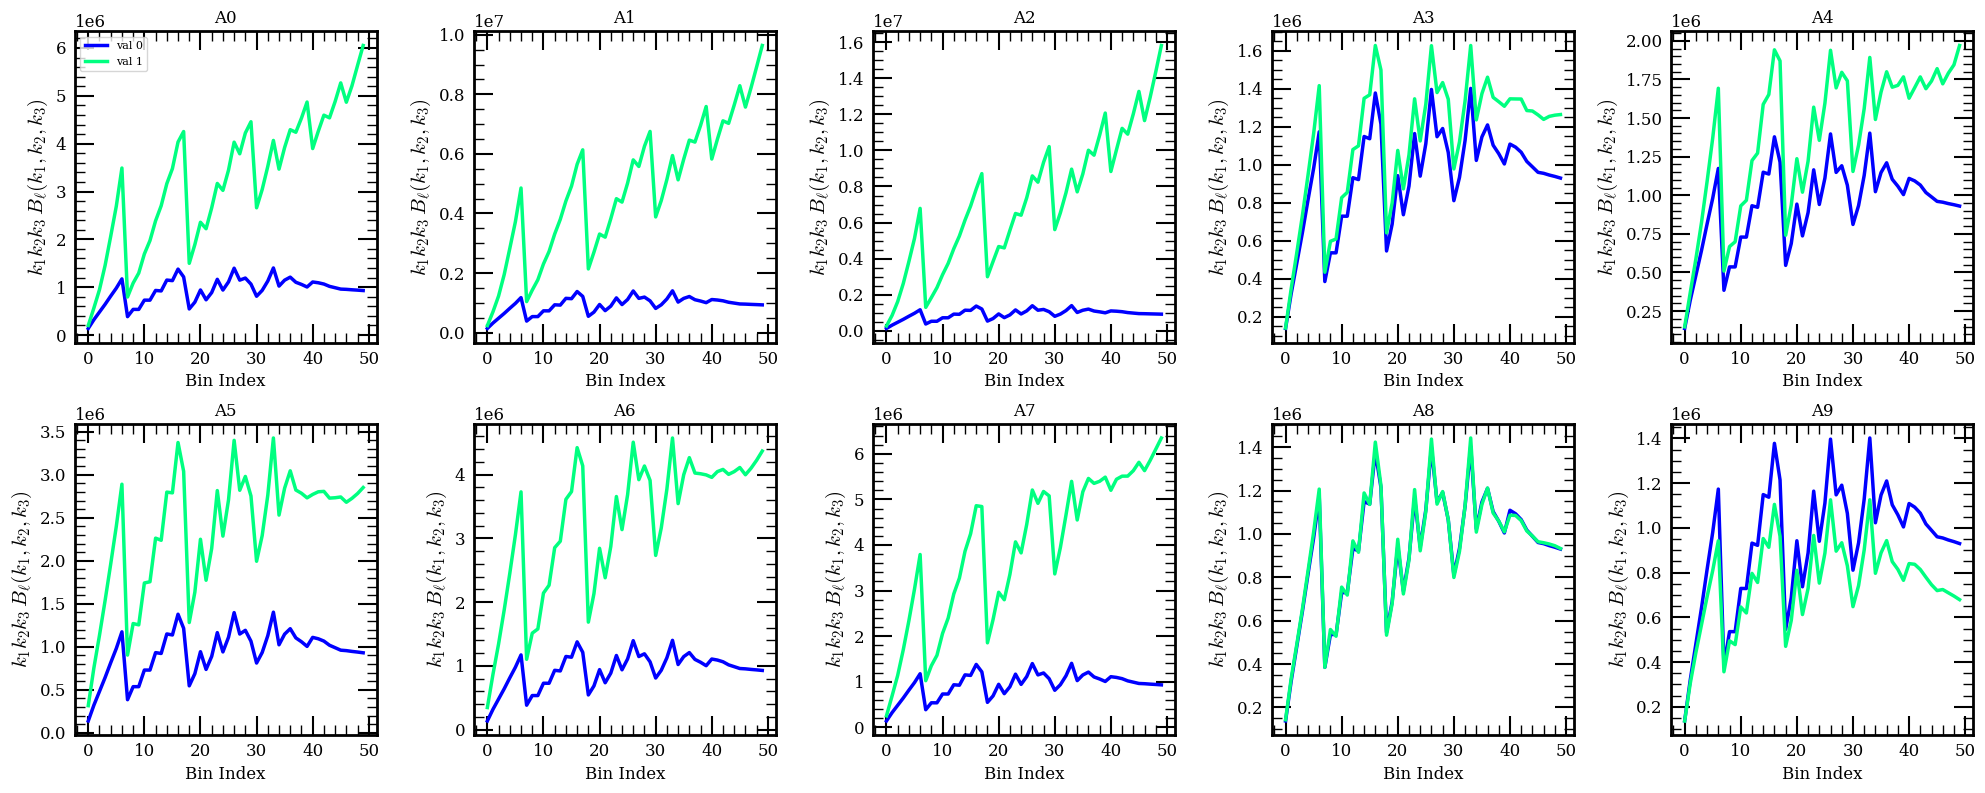

In [19]:
## Vary A_noise and A2_noise parameters - Plot Bispectrum

# Create grid plots: 2 rows x 5 columns
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

colors = plt.cm.winter(np.linspace(0, 1, n_Abins))

# Plot bk for different parameters
for i in range(n_noiseparams):
    ax = axes[i]
    # Plot with different colors for each parameter value
    for j in range(n_Abins):
        ax.plot(bk_results_arr[i][j]['bk'], color=colors[j], label=f'val {j}' if i == 0 else None)

    ax.set_xlabel(r'Bin Index', fontsize=12)
    ax.set_ylabel(r'$k_1k_2k_3\,B_\ell(k_1,k_2,k_3)$', fontsize=15)
    ax.set_title(f'A{i}', fontsize=12)
    if i == 0:
        ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


### try a fit

first get errors

In [13]:
data_mode = 'muchisimocks'
statistics = ['pk', 'bispec']
#statistics = ['pk']

### train
tag_params = '_p5_n10000'
tag_biasparams = '_biaszen_p4_n10000'
tag_noise = '_noise_unit_p5_n10000'
tag_Anoise = '_Anmult_p5_n10000'
### test
# tag_params = '_test_p5_n1000'
# tag_biasparams = '_biaszen_p4_n1000'
# tag_noise = '_noise_unit_test_p5_n1000'
# tag_Anoise = '_Anmult_p5_n1000'
## cosmic variance (quijote)
# tag_params="_quijote_p0_n1000"
# tag_biasparams="_b1000_p0_n1"
# tag_noise="_noise_quijote_p0_n1000"
# tag_Anoise="_An1_p0_n1"
tag_datagen = ''
kwargs_data = {
    'tag_datagen': tag_datagen
}

tag_stats = f'_{"_".join(statistics)}'    
tag_data = '_'+data_mode + tag_stats + tag_params + tag_biasparams + tag_datagen
k_arr_np5, y_arr_np5, y_err_np5, idxs_params_np5, params_df_np5, param_dict_fixed_np5, biasparams_df_np5, biasparams_dict_fixed_np5, Anoise_df_np5, Anoise_dict_fixed_np5, random_ints_np5, random_ints_bias_np5 = \
            data_loader.load_data(data_mode, statistics, 
                                    tag_params, tag_biasparams,
                                    tag_noise=tag_noise, tag_Anoise=tag_Anoise,
                                    tag_data=tag_data,
                                    kwargs=kwargs_data)
            
print(y_arr_np5[0].shape)
#print(y_arr[1].shape)

dir_statistics: /scratch/kstoreyf/muchisimocks/data/pks_mlib/pks_p5_n10000_biaszen_p4_n10000_noise_unit_p5_n10000_Anmult_p5_n10000
Loading muchisimocks data from /scratch/kstoreyf/muchisimocks/data/pks_mlib/pks_p5_n10000_biaszen_p4_n10000_noise_unit_p5_n10000_Anmult_p5_n10000
Found 10000 diff cosmo pks in /scratch/kstoreyf/muchisimocks/data/pks_mlib/pks_p5_n10000_biaszen_p4_n10000_noise_unit_p5_n10000_Anmult_p5_n10000
Loaded pk data with shape (10000, 30)
fn_mask: ../data/masks/mask_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n10000.txt
Loading from ../data/masks/mask_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n10000.txt (already exists)
Masked 1 out of 30 bins
(29,) (10000, 30) (10000, 30) (30,)
dir_statistics: /scratch/kstoreyf/muchisimocks/data/bispecs_mlib/bispecs_p5_n10000_biaszen_p4_n10000_noise_unit_p5_n10000_Anmult_p5_n10000
Loading muchisimocks data from /scratch/kstoreyf/muchisimocks/data/bispecs_mlib/bispecs_p5_n10000_biaszen_p4_n10000_noise_unit_p5_n10000_Anmult_p5_n10000


In [14]:
mask_pk = data_loader.get_Pk_mask(tag_data)

fn_mask: ../data/masks/mask_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n10000.txt
Loading from ../data/masks/mask_muchisimocks_pk_bispec_p5_n10000_biaszen_p4_n10000.txt (already exists)


In [15]:
theta_np5, param_names_np5 = data_loader.param_dfs_to_theta(idxs_params_np5, params_df_np5, biasparams_df_np5, Anoise_df=Anoise_df_np5)

In [16]:
# unpack the stats
k_pk_np5 = k_arr_np5[statistics.index('pk')]
y_pk_np5 = y_arr_np5[statistics.index('pk')]

k_bispec_np5 = k_arr_np5[statistics.index('bispec')]
y_bispec_np5 = y_arr_np5[statistics.index('bispec')]

In [17]:
pk_mean_lh_np5 = np.mean(y_pk_np5, axis=0)
pk_p16_lh_np5 = np.percentile(y_pk_np5, 16, axis=0)
pk_p84_lh_np5 = np.percentile(y_pk_np5, 84, axis=0)
pk_err_lh_np5 = (pk_p84_lh_np5 - pk_p16_lh_np5)/2

In [18]:
bispec_mean_lh_np5 = np.mean(y_bispec_np5, axis=0)
bispec_p16_lh_np5 = np.percentile(y_bispec_np5, 16, axis=0)
bispec_p84_lh_np5 = np.percentile(y_bispec_np5, 84, axis=0)
bispec_err_lh_np5 = (bispec_p84_lh_np5 - bispec_p16_lh_np5)/2

In [19]:
param_ranges_A = [
    [0.0, 2.0],   # A_noise[0]
    [0.0, 2.0],   # A_noise[1]
    [0.0, 2.0],   # A_noise[2]
    [0.0, 2.0],   # A_noise[3]
    [0.0, 20.0],  # A_noise[4]
]
param_ranges_A2 = [
    [0.0, 0.5],   # A2_noise[0]
    [0.0, 0.5],   # A2_noise[1]
    [0.0, 0.5],   # A2_noise[2]
    [0.0, 0.5],   # A2_noise[3]
    [0.0, 5.0]    # A2_noise[4]
]

bounds = param_ranges_A + param_ranges_A2

In [31]:
## Updated fit_noise_parameters with idxs_Anoise_vary support

def fit_noise_parameters(pk_obs, bk_obs, pk_err, bk_err, mask_pk, bias_terms_eul, 
                             tracer_field_noiseless, noise_field_unit, cosmo, box_size, n_grid,
                             n_grid_orig, base_bispec,
                             idxs_Anoise_vary, bounds, As_noise_fixed=None, A2s_noise_fixed=None,
                             initial_params=None, use_pk=True, use_bk=True, 
                             method='L-BFGS-B'):
    """
    Fit noise parameters to observed pk and bk.
    
    Parameters:
    -----------
    idxs_Anoise_vary : list
        Indices (0-9) of parameters to vary. 0-4 are A_noise, 5-9 are A2_noise
    As_noise_fixed : list, optional
        Fixed values for A_noise [0-4]. Default: [0,0,0,0,0]
    A2s_noise_fixed : list, optional
        Fixed values for A2_noise [0-4]. Default: [0,0,0,0,0]
    initial_params : array, optional
        Initial guess for varying parameters only. Default: zeros
    """
    from scipy.optimize import minimize
    
    gc.collect()
    
    # Set fixed values
    if As_noise_fixed is None:
        As_noise_fixed = [0.0, 0.0, 0.0, 0.0, 0.0]
    if A2s_noise_fixed is None:
        A2s_noise_fixed = [0.0, 0.0, 0.0, 0.0, 0.0]
    
    # Convert to arrays
    As_noise_fixed = np.array(As_noise_fixed)
    A2s_noise_fixed = np.array(A2s_noise_fixed)
    
    # Set initial parameters for varying ones only
    if initial_params is None:
        initial_params = np.zeros(len(idxs_Anoise_vary))
    
    def params_to_full(params_vary):
        """Convert varying parameters to full 10-parameter array."""
        params_full = np.zeros(10)
        # Set fixed values
        params_full[:5] = As_noise_fixed.copy()
        params_full[5:] = A2s_noise_fixed.copy()
        # Set varying values
        for idx, val in zip(idxs_Anoise_vary, params_vary):
            params_full[idx] = val
        return params_full
    
    def compute_model_statistics(params_vary):
        """Compute model pk and bk for given varying parameters."""
        # Convert to full parameter array
        params_full = params_to_full(params_vary)
        # Split parameters into A_noise and A2_noise
        As_noise = params_full[:5]
        A2s_noise = params_full[5:]
        
        # Create tracer field
        tracer_field_noise = np.sum([As_noise[i] * noise_field_unit * bias_terms_eul[i] 
                                     for i in range(len(As_noise))], axis=0) / n_grid_orig**3
        tracer_field_noise2 = np.sum([A2s_noise[i] * noise_field_unit**2 * bias_terms_eul[i] 
                                     for i in range(len(A2s_noise))], axis=0) / n_grid_orig**3
        tracer_field = tracer_field_noiseless + tracer_field_noise + tracer_field_noise2
        
        pk_obj, bspec, bk_corr = None, None, None
        # Compute model statistics
        if use_pk:
            pk_obj = cs.compute_pk(tracer_field, cosmo, box_size, n_threads=1, fn_stat=None)
        
        if use_bk:
            bspec, bk_corr = cs.compute_bispectrum(base_bispec, tracer_field)
        
        return pk_obj, bspec, bk_corr
    
    def objective(params_vary):
        """Objective function to minimize."""
        pk_obj, bspec, bk_corr = compute_model_statistics(params_vary)
        chi2 = 0.0
        
        if use_pk and pk_obj is not None:
            # Normalize by observed values to make it dimensionless
            pk_model = pk_obj['pk']
            diff = (pk_model[mask_pk] - pk_obs[mask_pk])**2 / pk_err**2
            #diff = (pk_model[mask_pk] - pk_obs[mask_pk])/pk_obs[mask_pk]
            chi2 += np.sum(diff)
        
        if use_bk and bk_corr is not None:
            # Normalize by observed values to make it dimensionless
            k123 = bspec.get_ks()
            weight = k123.prod(axis=0)
            norm = n_grid**3
            bk_model = norm**3 * weight * bk_corr['b0']

            diff = (bk_model - bk_obs)**2 / bk_err**2
            chi2 += np.sum(diff)
        print("params_vary", params_vary)
        print("chi2", chi2)
        return chi2
    
    # Perform optimization
    print(f"Starting optimization with method: {method}")
    print(f"Varying parameters at indices: {idxs_Anoise_vary}")
    print(f"Initial params: {initial_params}")
    bounds_vary = np.array(bounds)[idxs_Anoise_vary]
    #result_opt = minimize(objective, initial_params, method=method, 
    #                     options={'maxiter': 100, 'disp': True})
    result_opt = minimize(objective, initial_params, method=method, 
                        bounds=bounds_vary,
                        options={'maxfun': 50, 'ftol': 1e-2, 'eps': 1e-4, 'disp': True})
    # result_opt = minimize(objective, initial_params, method='Nelder-Mead',
    #              options={'maxfev': 50, 'xatol': 1}, bounds=bounds_vary)
                        
    
    # Compute final model statistics
    pk_obj_final, bspec_final, bk_corr_final = compute_model_statistics(result_opt.x)
    
    # Get full parameter array
    params_full = params_to_full(result_opt.x)
    
    # Prepare output
    result = {
        'params': params_full,
        'params_vary': result_opt.x,
        'As_noise': params_full[:5],
        'A2s_noise': params_full[5:],
        'idxs_vary': idxs_Anoise_vary,
        'success': result_opt.success,
        'message': result_opt.message,
        'result_opt': result_opt,
        'pk_obj_model': pk_obj_final,
        'bspec_model': bspec_final,
        'bk_corr_model': bk_corr_final,
        'n_iter': result_opt.nit if hasattr(result_opt, 'nit') else None
    }
    
    return result

In [32]:
# Example usage:
result = fit_noise_parameters(
    pk_obs=y_mock[0],  # observed pk
    bk_obs=y_mock[1],  # observed bk  
    pk_err=pk_err_lh_np5,
    bk_err=bispec_err_lh_np5,
    mask_pk=mask_pk,
    bias_terms_eul=bias_terms_eul,
    tracer_field_noiseless=tracer_field_noiseless,
    noise_field_unit=noise_field_unit,
    cosmo=cosmo,
    box_size=box_size,
    n_grid=n_grid,
    n_grid_orig=n_grid_orig,
    base_bispec=base,
    # initial_params=np.array([0.5, 0.5]),
    # idxs_Anoise_vary=[0,1],
    # initial_params=np.array([0.5,0.5,0.5,0.5,5.0]),
    # idxs_Anoise_vary=[0,1,2,3,4],
    initial_params=np.array([0.5,0.5,0.5,0.5]),
    idxs_Anoise_vary=[0,1,5,6],
    bounds=bounds,
    use_pk=True,
    use_bk=True
)

Starting optimization with method: L-BFGS-B
Varying parameters at indices: [0, 1, 5, 6]
Initial params: [0.5 0.5 0.5 0.5]
Computing pk, using n_grid =  128


2026-01-06 23:21:05,316 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-01-06 23:21:05,384 bacco.statistics :  ...done in 0.0683 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.50154 (grid1) 1.50154 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013687 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041996 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000125 secs
bacco.power : Deallocating arrays

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix
params_vary [0.5 0.5 0.5 0.5]
chi2 63.30119601227125
Computing pk, using n_grid =  128


2026-01-06 23:21:12,824 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-01-06 23:21:12,890 bacco.statistics :  ...done in 0.0661 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.50154 (grid1) 1.50154 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013535 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041362 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000120 secs
bacco.power : Deallocating arrays

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix
params_vary [0.5001 0.5    0.5    0.5   ]
chi2 63.30283611721684
Computing pk, using n_grid =  128


2026-01-06 23:21:19,658 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-01-06 23:21:19,725 bacco.statistics :  ...done in 0.0669 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.50154 (grid1) 1.50154 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013586 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041433 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000122 secs
bacco.power : Deallocating arrays

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix
params_vary [0.5    0.5001 0.5    0.5   ]
chi2 63.303241219414616
Computing pk, using n_grid =  128


2026-01-06 23:21:26,686 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-01-06 23:21:26,753 bacco.statistics :  ...done in 0.0672 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.50144 (grid1) 1.50144 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013643 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041663 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000126 secs
bacco.power : Deallocating arrays

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix
params_vary [0.5    0.5    0.4999 0.5   ]
chi2 63.284320428678285
Computing pk, using n_grid =  128


2026-01-06 23:21:33,757 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-01-06 23:21:33,823 bacco.statistics :  ...done in 0.0661 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.50154 (grid1) 1.50154 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013614 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041661 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000121 secs
bacco.power : Deallocating arrays

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix
params_vary [0.5    0.5    0.5    0.4999]
chi2 63.28244740724671
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         2 variables are exactly at the bounds

At iterate  

2026-01-06 23:21:40,789 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-01-06 23:21:40,856 bacco.statistics :  ...done in 0.0678 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013911 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.042090 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000126 secs
bacco.power : Deallocating arrays

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix
params_vary [0. 0. 0. 0.]
chi2 0.9923159158636617
Computing pk, using n_grid =  128


2026-01-06 23:21:50,227 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-01-06 23:21:50,295 bacco.statistics :  ...done in 0.0672 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013727 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041613 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000121 secs
bacco.power : Deallocating arrays

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix
params_vary [0.0001 0.     0.     0.    ]
chi2 0.9923142486628422
Computing pk, using n_grid =  128


2026-01-06 23:21:59,947 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-01-06 23:22:00,014 bacco.statistics :  ...done in 0.067 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013685 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041683 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000126 secs
bacco.power : Deallocating arrays

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix
params_vary [0.     0.0001 0.     0.    ]
chi2 0.9923164545203975
Computing pk, using n_grid =  128


2026-01-06 23:22:10,297 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-01-06 23:22:10,366 bacco.statistics :  ...done in 0.0696 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.0001 (grid1) 1.0001 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013634 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.042565 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000134 secs
bacco.power : Deallocating arrays

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix
params_vary [0.     0.     0.0001 0.    ]
chi2 0.9922329267147634
Computing pk, using n_grid =  128


2026-01-06 23:22:20,695 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-01-06 23:22:20,764 bacco.statistics :  ...done in 0.0686 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013560 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.042016 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000122 secs
bacco.power : Deallocating arrays

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix
params_vary [0.     0.     0.     0.0001]
chi2 0.9921669538034509

At iterate    1    f=  9.92316D-01    |proj g|=  5.00000D-01
Computing pk, using n_grid =  128


2026-01-06 23:22:31,663 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-01-06 23:22:31,731 bacco.statistics :  ...done in 0.0679 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.00168 (grid1) 1.00168 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.014023 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041715 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000126 secs
bacco.power : Deallocating arrays

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix
params_vary [0.00143833 0.         0.00167489 0.00339429]
chi2 0.9863714431919813
Computing pk, using n_grid =  128


2026-01-06 23:22:40,582 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.00168 (grid1) 1.00168 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013850 sec
bacco.power : Counting modes


2026-01-06 23:22:40,659 bacco.statistics :  ...done in 0.0773 s


bacco.power : done counting modes in 0.041992 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000131 secs
bacco.power : Deallocating arrays

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix
params_vary [0.00153833 0.         0.00167489 0.00339429]
chi2 0.9863691481256677
Computing pk, using n_grid =  128


2026-01-06 23:22:51,972 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-01-06 23:22:52,041 bacco.statistics :  ...done in 0.0689 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.00168 (grid1) 1.00168 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013574 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041990 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000124 secs
bacco.power : Deallocating arrays

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix
params_vary [0.00143833 0.0001     0.00167489 0.00339429]
chi2 0.9863714887641841
Computing pk, using n_grid =  128


2026-01-06 23:23:01,649 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-01-06 23:23:01,716 bacco.statistics :  ...done in 0.0677 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.00178 (grid1) 1.00178 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013509 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.042343 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000121 secs
bacco.power : Deallocating arrays

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix
params_vary [0.00143833 0.         0.00177489 0.00339429]
chi2 0.9863099195212033
Computing pk, using n_grid =  128


2026-01-06 23:23:14,155 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-01-06 23:23:14,222 bacco.statistics :  ...done in 0.0665 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.00168 (grid1) 1.00168 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013495 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041658 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000120 secs
bacco.power : Deallocating arrays

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix
params_vary [0.00143833 0.         0.00167489 0.00349429]
chi2 0.9862434566147078

At iterate    2    f=  9.86371D-01    |proj g|=  4.98325D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tn

2026-01-06 23:23:24,195 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-01-06 23:23:24,262 bacco.statistics :  ...done in 0.0669 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 1; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1.00168 (grid1) 1.00168 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.013584 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.041627 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000137 secs
bacco.power : Deallocating arrays

Binning: 7 bins in [0.010, 0.400] h/Mpc
Squezed binning: 7 bins in [0.010, 0.400] h/Mpc
l-max: 1
N_bins: 50
Mask: constant
Computing degeneracy factor
Computing ideal Fisher matrix


In [22]:
print(f"Fitted A_noise: {result['As_noise']}")
print(f"Fitted A2_noise: {result['A2s_noise']}")
print(f"Success: {result['success']}")

Fitted A_noise: [0.62688887 0.63830748 0.         0.         4.99971355]
Fitted A2_noise: [0. 0. 0. 0. 0.]
Success: True


In [23]:
result['result_opt']

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.5582143179324213
        x: [ 6.269e-01  6.383e-01  5.000e+00]
      nit: 1
      jac: [-1.392e-01 -1.115e-01 -3.219e-03]
     nfev: 12
     njev: 3
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>

In [33]:
result['result_opt']

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.9863714431919813
        x: [ 1.438e-03  0.000e+00  1.675e-03  3.394e-03]
      nit: 2
      jac: [-2.295e-02  4.557e-04 -6.152e-01 -1.280e+00]
     nfev: 15
     njev: 3
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

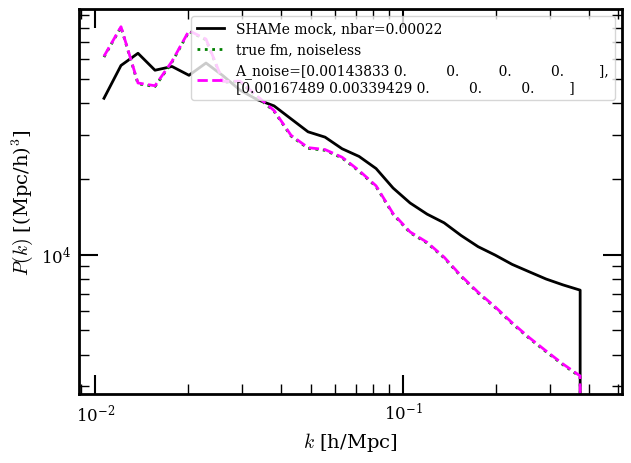

In [34]:
plt.figure(figsize=(7,5))

label = f'SHAMe mock, nbar={tag_mock.split("nbar")[-1]}'
plt.plot(k_mock[0], y_mock[0], color='black', label=label, lw=2)
plt.plot(pk_noiseless['k'], pk_noiseless['pk'], color='green', ls=':', label='true fm, noiseless', lw=2)

pk_obj_model = result['pk_obj_model']
plt.plot(pk_obj_model['k'], pk_obj_model['pk'], color='magenta', ls='--', 
         label=f'A_noise={result["As_noise"]},\n{result["A2s_noise"]}', lw=2)

plt.xscale('log')
plt.yscale('log') 
plt.xlabel(r'$k$ [h/Mpc]', fontsize=14)
plt.ylabel(r'$P(k)$ [(Mpc/h)$^3$]', fontsize=14)

plt.legend(fontsize=10, loc='upper right')

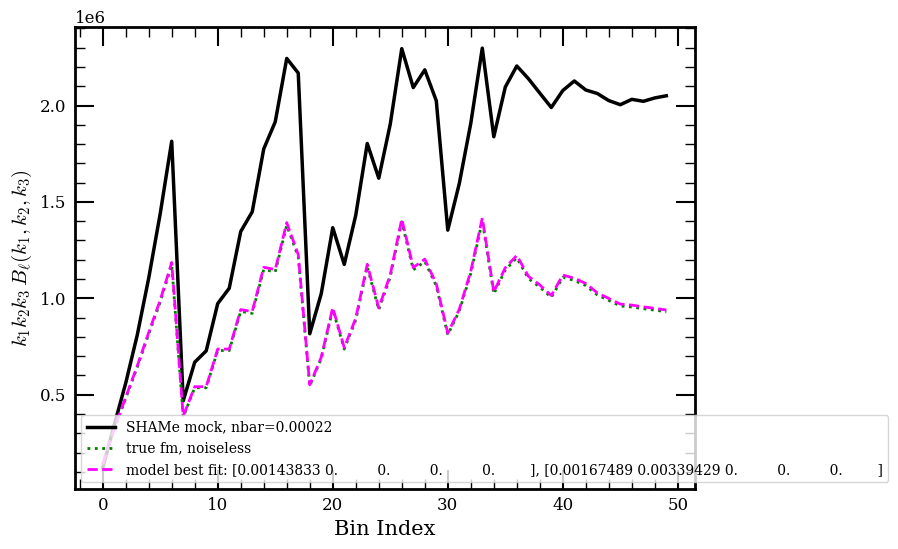

: 

In [ ]:
plt.figure(figsize=(8,6))

# ks & norm same for all
k123 = bspec_noiseless.get_ks()
weight = k123.prod(axis=0)

norm = n_grid**3
#norm_mock = n_grid_mock**3
#print(norm, norm_mock)

label = f'SHAMe mock, nbar={tag_mock.split("nbar")[-1]}'

plt.plot(y_mock[1], color='black', label=label)
plt.plot(norm**3 * weight*bk_corr_noiseless['b0'], color='green', ls=':', label='true fm, noiseless', lw=2)
bk_corr_model = result['bk_corr_model']
plt.plot(norm**3 * weight*bk_corr_model['b0'], color='magenta', ls='--', 
        label=f'model best fit: {result["As_noise"]}, {result["A2s_noise"]}', lw=2)

plt.xlabel(r'Bin Index',fontsize=15)
plt.ylabel(r'$k_1k_2k_3\,B_\ell(k_1,k_2,k_3)$',fontsize=15)
plt.legend(fontsize=10)
        